# Term Project : DSCI 631

## Team Members:

- Caleb Miller : cm3962@drexel.edu
    - Background : Caleb’s undergraduate background in Business Analytics gives him a unique perspective on Data Science. He has general knowledge of how a business operates, technical knowledge of an analyst/data scientist, and understands the divide between these departments and the executive suite. He aims to be a bridge between these departments. He has worked with a lot of data relating to sports, as his hope is to enter the world of sports analytics/science. His self identified skills include: Python, R, Java, C++, SQL, VBA, Pandas, NumPy, Dash, Matplotlib, Tableau, PowerBI, Model Development and Evaluation, Scikit-Learn, Requests, Selenium, BeautifulSoup4, Monte Carlo Simulation.
- Robert Logovinsky : rsl32@drexel.edu
    - Robert brings with him a robust background in data analysis and IT support, which are complemented by extensive experience with diverse datasets across multiple domains including finance, logistics, and sports. His recent studies have significantly enhanced his coding abilities in Python, Java, and C. More specifically, the numerous Python libraries that he has studied have been instrumental in honing in vital Data Science skills related to data cleaning, EDA and modeling.
- Hashim Afzal : ha695@drexel.edu
    - Background : Hashim has an undergraduate degree in Biology from Arizona State University and has completed research in the field of cellular biology at the Biodesign Institute studying infectious diseases. Now Hashim is at Drexel University studying Data Science. Prior to starting at Drexel, Hashim worked as an analyst where he designed and implemented transaction monitoring rules in the FinTech space. His self-identified skills are in statistical analysis and study design utilizing the scientific method.



## Motivation Behind the Project:

The goal of this project is to develop a model that will estimate whether or not a pitch will be called a strike when the batter does ***not*** swing at it. Estimating whether or not a taken pitch will be called a strike is a key project for baseball teams. This model allows teams to leverage estimates of strike probability for various applications, such as evaluating catcher framing, making swing decisions, and analyzing umpire tendencies. 

## Detailed Description of Dataset:

The dataset that we acquired is a collection of pitches from the 2022 MLB Season where the batter did not swing at the pitch. This dataset was sourced from baseballsavant.mlb.com and has 351,062 rows and 20 columns. 

### Column Breakdown: 

- game_pk : unique identifier for a specific game - data type is an integer
- game_date : the date on which the game occurred in the format MM/DD/YYYY - data type is date
- at_bat_number : unique identifier for a specific plate apperance - data type is an integer
- pitch_number : pitch number within the plate appearance - data type is integer
- pitch_type : identifies what type of pitch was thrown - data type is string
    - can be one of:
        - CH : changeup
        - CS, CU : curveball
        - EP : eephus
        - FA, FF : four seam fastball
        - FC : cutter
        - FS : splitter
        - KC : knuckle curve
        - KN : knuckleball
        - SI : sinker
        - SL : slider
- pitcher_name : name of the pitcher in lastname, firstname format - data type is string
- pitcher : unique identifier for pitcher - data type is integer
- batter : unique identifier for batter - date type is integer
- catcher : unique identifier for catcher - data type is integer
- description : describes whether a pitch was called a ball or strike - data type is string
- zone : describes the zone location a ball when it crosses the plate - data type is integer
- stand : whether the batter is left-handed or right-handed - data type is string
    - can be one of:
        - L : left-handed
        - R : right-handed
- p_throws : whether the pitcher is left-handed or right-handed - data type is string
    - can be one of:
        - L : left-handed
        - R : right-handed
- balls : how many balls are in the count at the time of the pitch - data type is integer
- strikes : how many strikes are in the count at the time of the pitch - data type is integer
- plate_x : horizontal position of the ball when it crosses the plate - data type is float
    - center of the plate is 0,0, units in feet 
- plate_z : vertical position of the ball when it crosses the plate - data type is float
    - the ground is 0,0, units in feet 
- sz_top : top of the batter's strike zone - set by the operator when the ball is halfway to the plate - data type is float
- sz_bottom : bottom of the batter's strike zone - set by the operator when the ball is halfway to the plate - data type is float
- broadcast : Link to a video of the pitch - data type is string

## Data Preprocessing

In [8]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from scipy import stats
from scipy.stats import norm

import seaborn as sns

from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (classification_report, make_scorer, accuracy_score, 
                             precision_score, recall_score, f1_score, 
                             confusion_matrix, ConfusionMatrixDisplay)

from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Nadam

from scikeras.wrappers import KerasClassifier

import time

In [9]:
df = pd.read_csv('k_prob.csv')
print(df.isnull().any())

game_pk          False
game_date        False
at_bat_number    False
pitch_number     False
pitch_type        True
pitcher_name     False
pitcher          False
batter           False
catcher          False
description      False
zone              True
stand            False
p_throws         False
balls            False
strikes          False
plate_x           True
plate_z           True
sz_top            True
sz_bot            True
broadcast         True
dtype: bool


In [10]:
df.game_pk

0         662588
1         662588
2         662588
3         662123
4         663205
           ...  
351057    663419
351058    661954
351059    661735
351060    661954
351061    661096
Name: game_pk, Length: 351062, dtype: int64

In [11]:
df.pitcher = df.pitcher.astype(str)
df.game_pk = df.game_pk.astype(str)
df.batter = df.batter.astype(str)
df.catcher = df.catcher.astype(str)

In [12]:
df1 = df.dropna()
df1.rename(columns = {'game_pk':'game_id', 'pitcher':'pitcher_id', 'catcher':'catcher_id', 'batter':'batter_id'}, inplace=True)
df1.dtypes


C:\Users\Caleb\AppData\Local\Temp\ipykernel_1580\713034893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns = {'game_pk':'game_id', 'pitcher':'pitcher_id', 'catcher':'catcher_id', 'batter':'batter_id'}, inplace=True)


game_id           object
game_date         object
at_bat_number      int64
pitch_number       int64
pitch_type        object
pitcher_name      object
pitcher_id        object
batter_id         object
catcher_id        object
description       object
zone             float64
stand             object
p_throws          object
balls              int64
strikes            int64
plate_x          float64
plate_z          float64
sz_top           float64
sz_bot           float64
broadcast         object
dtype: object

In [13]:
df1.zone = df1.zone.astype(int)

C:\Users\Caleb\AppData\Local\Temp\ipykernel_1580\164135242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.zone = df1.zone.astype(int)


In [14]:
df1.head()

,game_id,game_date,at_bat_number,pitch_number,pitch_type,pitcher_name,pitcher_id,batter_id,catcher_id,description,zone,stand,p_throws,balls,strikes,plate_x,plate_z,sz_top,sz_bot,broadcast
0,662588,4/9/22,51,6,CH,"Bassitt, Chris",605135,605137,543510,called_strike,8,L,R,2,2,0.17,2.20,3.74,1.82,https://sporty-clips.mlb.com/1034420a-0db5-43b...
1,662588,4/9/22,51,5,FC,"Bassitt, Chris",605135,605137,543510,ball,11,L,R,1,2,-0.92,5.43,3.75,1.83,https://sporty-clips.mlb.com/3c758e31-1f42-4ed...
2,662588,4/9/22,51,1,SL,"Bassitt, Chris",605135,605137,543510,ball,14,L,R,0,0,0.86,1.28,3.51,1.58,https://sporty-clips.mlb.com/743d7d90-c6e5-40e...
3,662123,4/9/22,33,5,FF,"Rodón, Carlos",607074,643265,663698,ball,11,R,L,1,2,-0.15,5.07,3.58,1.85,https://sporty-clips.mlb.com/042a29c4-504c-49c...
4,663205,4/9/22,37,7,SL,"Woodruff, Brandon",605540,664023,605170,ball,14,L,R,2,2,1.46,2.40,3.40,1.60,https://sporty-clips.mlb.com/221061be-181c-43b...


In [15]:
print(df1.isnull().any())

game_id          False
game_date        False
at_bat_number    False
pitch_number     False
pitch_type       False
pitcher_name     False
pitcher_id       False
batter_id        False
catcher_id       False
description      False
zone             False
stand            False
p_throws         False
balls            False
strikes          False
plate_x          False
plate_z          False
sz_top           False
sz_bot           False
broadcast        False
dtype: bool


no more null values

In [16]:
shape = df1.shape
print(shape)

(350864, 20)


lost less than 0.5% of data - better than imputing

In [17]:
df1 = df1.drop(columns=['pitcher_name'])

drop pitcher name due to lack of info for ML algorithm - data captured in pitcher_id

In [18]:
df1['description'] = df1['description'].replace({'ball': 0, 'called_strike': 1})

C:\Users\Caleb\AppData\Local\Temp\ipykernel_1580\2217854745.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['description'] = df1['description'].replace({'ball': 0, 'called_strike': 1})


### Potential analysis

Look at the pitch count 0-0 vs 3-0 vs 3-2 vs 0-2..can do each pitch count vs correct call %

group by each pitcher/batter/catcher (separately) and measure cc% for each (make sure sample size is large enough)

prob called strike & prob called ball for each zone

pitch type (x-axis) discreet
strike_called_strike (y-axis)
ball_called_strike (y-axis)

P(CC) vs Strike-Count(x-axis)

In [19]:
print(df1.head())

  game_id game_date  at_bat_number  pitch_number pitch_type pitcher_id  \
0  662588    4/9/22             51             6         CH     605135   
1  662588    4/9/22             51             5         FC     605135   
2  662588    4/9/22             51             1         SL     605135   
3  662123    4/9/22             33             5         FF     607074   
4  663205    4/9/22             37             7         SL     605540   

  batter_id catcher_id  description  zone stand p_throws  balls  strikes  \
0    605137     543510            1     8     L        R      2        2   
1    605137     543510            0    11     L        R      1        2   
2    605137     543510            0    14     L        R      0        0   
3    643265     663698            0    11     R        L      1        2   
4    664023     605170            0    14     L        R      2        2   

   plate_x  plate_z  sz_top  sz_bot  \
0     0.17     2.20    3.74    1.82   
1    -0.92     5.43 

In [20]:
df1["bats_lefty"] = df1["stand"]
df1["pitches_lefty"] = df1["p_throws"]

In [21]:
df1['bats_lefty'] = df1['bats_lefty'].replace({'R': 0, 'L': 1})
df1['pitches_lefty'] = df1['pitches_lefty'].replace({'R': 0, 'L': 1})

C:\Users\Caleb\AppData\Local\Temp\ipykernel_1580\2190153718.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['bats_lefty'] = df1['bats_lefty'].replace({'R': 0, 'L': 1})
C:\Users\Caleb\AppData\Local\Temp\ipykernel_1580\2190153718.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['pitches_lefty'] = df1['pitches_lefty'].replace({'R': 0, 'L': 1})


In [22]:
df1 = df1.drop(columns = ["stand"])
df1 = df1.drop(columns = ["p_throws"])

In [23]:
df1.head()

,game_id,game_date,at_bat_number,pitch_number,pitch_type,pitcher_id,batter_id,catcher_id,description,zone,balls,strikes,plate_x,plate_z,sz_top,sz_bot,broadcast,bats_lefty,pitches_lefty
0,662588,4/9/22,51,6,CH,605135,605137,543510,1,8,2,2,0.17,2.20,3.74,1.82,https://sporty-clips.mlb.com/1034420a-0db5-43b...,1,0
1,662588,4/9/22,51,5,FC,605135,605137,543510,0,11,1,2,-0.92,5.43,3.75,1.83,https://sporty-clips.mlb.com/3c758e31-1f42-4ed...,1,0
2,662588,4/9/22,51,1,SL,605135,605137,543510,0,14,0,0,0.86,1.28,3.51,1.58,https://sporty-clips.mlb.com/743d7d90-c6e5-40e...,1,0
3,662123,4/9/22,33,5,FF,607074,643265,663698,0,11,1,2,-0.15,5.07,3.58,1.85,https://sporty-clips.mlb.com/042a29c4-504c-49c...,0,1
4,663205,4/9/22,37,7,SL,605540,664023,605170,0,14,2,2,1.46,2.40,3.40,1.60,https://sporty-clips.mlb.com/221061be-181c-43b...,1,0


In [24]:
df1.dtypes

game_id           object
game_date         object
at_bat_number      int64
pitch_number       int64
pitch_type        object
pitcher_id        object
batter_id         object
catcher_id        object
description        int64
zone               int32
balls              int64
strikes            int64
plate_x          float64
plate_z          float64
sz_top           float64
sz_bot           float64
broadcast         object
bats_lefty         int64
pitches_lefty      int64
dtype: object

In [25]:
df1 = df1.rename(columns = {"description":"is_strike"})

In [26]:
df1['ball_called_ball'] = 0
df1['strike_called_ball'] = 0
df1['ball_called_strike'] = 0
df1['strike_called_strike'] = 0


In [27]:
df1.head()

,game_id,game_date,at_bat_number,pitch_number,pitch_type,pitcher_id,batter_id,catcher_id,is_strike,zone,...,plate_z,sz_top,sz_bot,broadcast,bats_lefty,pitches_lefty,ball_called_ball,strike_called_ball,ball_called_strike,strike_called_strike
0,662588,4/9/22,51,6,CH,605135,605137,543510,1,8,...,2.20,3.74,1.82,https://sporty-clips.mlb.com/1034420a-0db5-43b...,1,0,0,0,0,0
1,662588,4/9/22,51,5,FC,605135,605137,543510,0,11,...,5.43,3.75,1.83,https://sporty-clips.mlb.com/3c758e31-1f42-4ed...,1,0,0,0,0,0
2,662588,4/9/22,51,1,SL,605135,605137,543510,0,14,...,1.28,3.51,1.58,https://sporty-clips.mlb.com/743d7d90-c6e5-40e...,1,0,0,0,0,0
3,662123,4/9/22,33,5,FF,607074,643265,663698,0,11,...,5.07,3.58,1.85,https://sporty-clips.mlb.com/042a29c4-504c-49c...,0,1,0,0,0,0
4,663205,4/9/22,37,7,SL,605540,664023,605170,0,14,...,2.40,3.40,1.60,https://sporty-clips.mlb.com/221061be-181c-43b...,1,0,0,0,0,0


In [28]:
df1.loc[(df1["is_strike"] == 0) & (df1["zone"].between(11,14)), "ball_called_ball"] = 1
df1.loc[(df1["is_strike"] == 0) & (df1["zone"].between(1,9)), "strike_called_ball"] = 1
df1.loc[(df1["is_strike"] == 1) & (df1["zone"].between(11,14)), "ball_called_strike"] = 1
df1.loc[(df1["is_strike"] == 1) & (df1["zone"].between(1,9)), "strike_called_strike"] = 1

## Exploratory Data Analysis (EDA)

In [29]:
x = df1["ball_called_strike"].sum()
y = df1["ball_called_ball"].sum()
total_balls = x + y
wrong_calls = x / total_balls
print('Total Balls Called: ', total_balls)
print('Percent of balls called that were strikes: ', wrong_calls)

Total Balls Called:  239156
Percent of balls called that were strikes:  0.06632490926424593


only 6% of balls were called strikes, incorrectly

In [30]:
x = df1["strike_called_strike"].sum()
y = df1["strike_called_ball"].sum()
total_strikes = x + y
wrong_calls = y / total_strikes
print('Total Strikes Called: ', total_strikes)
print('Percent of strikes called that were balls: ', wrong_calls)

Total Strikes Called:  111708
Percent of strikes called that were balls:  0.1053908404053425


on the contrary, 10% of strikes were called balls, incorrectly

On pitches where a batter does not swing, the umpire is twice as likely to call a ball than a strike. (based off total balls / total strikes)

Additionally, on these pitches, an umpire is more likely to call a strike a ball than call a ball a strike.

Hypothesis: If the batter is unsure of whether or not to swing at a pitch, a batter is better off not swinging than swinging.

In [31]:
df1['correct_call'] = 0

In [32]:
df1.loc[(df1["strike_called_strike"] == 1) | (df1["ball_called_ball"] ==1), "correct_call"] = 1

In [33]:
df1['p_lefty_correct_call'] = 0
df1['p_righty_correct_call'] = 0
df1['b_righty_correct_call'] = 0
df1['b_lefty_correct_call'] = 0
df1.head()

,game_id,game_date,at_bat_number,pitch_number,pitch_type,pitcher_id,batter_id,catcher_id,is_strike,zone,...,pitches_lefty,ball_called_ball,strike_called_ball,ball_called_strike,strike_called_strike,correct_call,p_lefty_correct_call,p_righty_correct_call,b_righty_correct_call,b_lefty_correct_call
0,662588,4/9/22,51,6,CH,605135,605137,543510,1,8,...,0,0,0,0,1,1,0,0,0,0
1,662588,4/9/22,51,5,FC,605135,605137,543510,0,11,...,0,1,0,0,0,1,0,0,0,0
2,662588,4/9/22,51,1,SL,605135,605137,543510,0,14,...,0,1,0,0,0,1,0,0,0,0
3,662123,4/9/22,33,5,FF,607074,643265,663698,0,11,...,1,1,0,0,0,1,0,0,0,0
4,663205,4/9/22,37,7,SL,605540,664023,605170,0,14,...,0,1,0,0,0,1,0,0,0,0


In [34]:
df1.loc[(df1["pitches_lefty"] == 1) & (df1["correct_call"] == 1), "p_lefty_correct_call"] = 1
df1.loc[(df1["pitches_lefty"] == 0) & (df1["correct_call"] == 1), "p_righty_correct_call"] = 1
df1.loc[(df1["bats_lefty"] == 1) & (df1["correct_call"] == 1), "b_lefty_correct_call"] = 1
df1.loc[(df1["bats_lefty"] == 0) & (df1["correct_call"] == 1), "b_righty_correct_call"] = 1
df1.head()


,game_id,game_date,at_bat_number,pitch_number,pitch_type,pitcher_id,batter_id,catcher_id,is_strike,zone,...,pitches_lefty,ball_called_ball,strike_called_ball,ball_called_strike,strike_called_strike,correct_call,p_lefty_correct_call,p_righty_correct_call,b_righty_correct_call,b_lefty_correct_call
0,662588,4/9/22,51,6,CH,605135,605137,543510,1,8,...,0,0,0,0,1,1,0,1,0,1
1,662588,4/9/22,51,5,FC,605135,605137,543510,0,11,...,0,1,0,0,0,1,0,1,0,1
2,662588,4/9/22,51,1,SL,605135,605137,543510,0,14,...,0,1,0,0,0,1,0,1,0,1
3,662123,4/9/22,33,5,FF,607074,643265,663698,0,11,...,1,1,0,0,0,1,1,0,1,0
4,663205,4/9/22,37,7,SL,605540,664023,605170,0,14,...,0,1,0,0,0,1,0,1,0,1


In [35]:
x = df1["p_lefty_correct_call"].sum()
y = df1['pitches_lefty'].sum()
p_lefty_correct_call_percent = (x/y) * 100

m = df1["p_righty_correct_call"].sum()
n = (df1['pitches_lefty'] == 0).sum()
p_righty_correct_call_percent = (m/n) * 100

print('Number of left handed pitches: ', y)
print('Number of right handed pitches: ', n)
print('Correct call percentage of left handed pitches: ', p_lefty_correct_call_percent)
print('Correct call percentage of right handed pitches: ', p_righty_correct_call_percent)

Number of left handed pitches:  95747
Number of right handed pitches:  255117
Correct call percentage of left handed pitches:  92.01019353086781
Correct call percentage of right handed pitches:  92.16633936585959


expected a lot more pitches from right handed pitchers if this is an all encompassing dataset of pitches thrown - analysis stays true with this 

In [36]:
x = df1["b_lefty_correct_call"].sum()
y = df1['bats_lefty'].sum()
b_lefty_correct_call_percent = (x/y) * 100

m = df1["b_righty_correct_call"].sum()
n = (df1['bats_lefty'] == 0).sum()
b_righty_correct_call_percent = (m/n) * 100

print('Number of pitches to left handed batters: ', y)
print('Number of pitches to right handed batters: ', n)
print('Correct call percentage to left handed batters: ', b_lefty_correct_call_percent)
print('Correct call percentage to right handed batters: ', b_righty_correct_call_percent)

Number of pitches to left handed batters:  143043
Number of pitches to right handed batters:  207821
Correct call percentage to left handed batters:  92.2296092783289
Correct call percentage to right handed batters:  92.05085145389542


### More Analysis

Pitches Left to Bats Left

Pitches Left to Bats Right

Pitches Right to Bats Right

Pitches Right to Bats Left

In [37]:
df1['pl_bl_cc'] = 0
df1['pl_br_cc'] = 0
df1['pr_br_cc'] = 0
df1['pr_bl_cc'] = 0

In [38]:
df1.loc[(df1["pitches_lefty"] == 1) & (df1["bats_lefty"] == 1) & (df1['correct_call'] == 1), "pl_bl_cc"] = 1
df1.loc[(df1["pitches_lefty"] == 1) & (df1["bats_lefty"] == 0) & (df1['correct_call'] == 1), "pl_br_cc"] = 1
df1.loc[(df1["pitches_lefty"] == 0) & (df1["bats_lefty"] == 0) & (df1['correct_call'] == 1), "pr_br_cc"] = 1
df1.loc[(df1["pitches_lefty"] == 0) & (df1["bats_lefty"] == 1) & (df1['correct_call'] == 1), "pr_bl_cc"] = 1


In [39]:
x = df1["pl_bl_cc"].sum()
y = ((df1['pitches_lefty'] == 1) & (df1['bats_lefty'] == 1) ).sum()
pl_bl_cc_percent = (x/y) * 100
print("Correct call percentage for pitches left and bats left: ", pl_bl_cc_percent)

m = df1["pl_br_cc"].sum()
n = ((df1['pitches_lefty'] == 1) & (df1['bats_lefty'] == 0 ) ).sum()
pl_br_cc_percent = (m/n) * 100
print("Correct call percentage for pitches left and bats right: ",pl_br_cc_percent)

a = df1["pr_bl_cc"].sum()
b = ((df1['pitches_lefty'] == 0 ) & (df1['bats_lefty'] == 1) ).sum()
pr_bl_cc_percent = (a/b) * 100
print("Correct call percentage for pitches right and bats left: ",pr_bl_cc_percent)

c = df1["pr_br_cc"].sum()
d = ((df1['pitches_lefty'] == 0) & (df1['bats_lefty'] == 0) ).sum()
pr_br_cc_percent = (c/d) * 100
print("Correct call percentage for pitches right and bats right: ",pr_br_cc_percent)


Correct call percentage for pitches left and bats left:  92.23972037858854
Correct call percentage for pitches left and bats right:  91.92703887086677
Correct call percentage for pitches right and bats left:  92.22741962918863
Correct call percentage for pitches right and bats right:  92.11412201807514


In [40]:
cc_perc = df1['correct_call'].sum() / (len(df1['correct_call'])) * 100
print("Overall correct call percentage: ", cc_perc)

Overall correct call percentage:  92.12372885220485


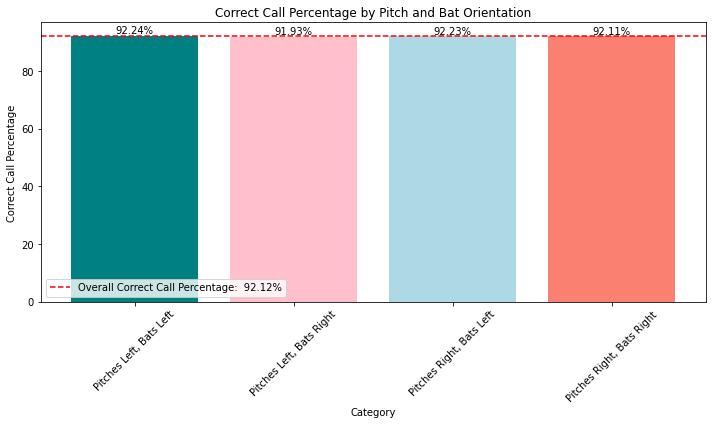

In [41]:
categories = ['Pitches Left, Bats Left', 'Pitches Left, Bats Right', 'Pitches Right, Bats Left', 'Pitches Right, Bats Right']

percentages = [pl_bl_cc_percent, pl_br_cc_percent, pr_bl_cc_percent, pr_br_cc_percent]

plt.figure(figsize=(10, 6))

plt.bar(categories, percentages, color=['teal', 'pink', 'lightblue', 'salmon'])

plt.axhline(y=cc_perc, color='r', linestyle='--', label=f'Overall Correct Call Percentage: {cc_perc: .2f}%')

plt.xlabel('Category')
plt.ylabel('Correct Call Percentage')
plt.title('Correct Call Percentage by Pitch and Bat Orientation')
plt.xticks(rotation=45)  


for i, percentage in enumerate(percentages):
    plt.text(i, percentage, f'{percentage:.2f}%', ha='center', va='bottom')

plt.legend()
plt.tight_layout()  
plt.show()

Handedness of a pitcher or batter, or a combination of the two has no impact on the umpires ability to make a correct call. Umpires are however, more likely to call a strike a ball when a batter does not swing as compared to determining a ball a strike (10% vs 6%)

One more consideration however, is whether an umpires ability to determine a correct call is impacted by pitch type. Or a combination of pitch type + handedness of either batter or pitcher.



Null Hypothesis (H0): There is no association between the handedness of the pitcher/batter and the correctness of the umpire's calls.

Alternative Hypothesis (H1): There is an association between the handedness of the pitcher/batter and the correctness of the umpire's calls.


In [42]:
cc_perc /= 100 # need cc percentage as a decimal for a/b testing

In [43]:
#lhp > lhb
p1 = cc_perc  # Proportion of correct calls for all pitches
p2 =  pl_bl_cc_percent / 100
N1 = len(df1)  # Total number of pitches for all situations
N2 = y

# Calculate pooled proportion
P_pooled = (p1 * N1 + p2 * N2) / (N1 + N2)

# Calculate the standard error
SE = np.sqrt(P_pooled * (1 - P_pooled) * (1/N1 + 1/N2))

# Calculate Z-statistic
Z = (p1 - p2) / SE

# Calculate the p-value
p_value = 2 * (1 - norm.cdf(abs(Z)))  # Two-tailed test

print("For left handed pitchers to left handed batters: ")

print("Z-Score: ", Z, ", P-Value: ", p_value)

print('Fail to reject H0')


For left handed pitchers to left handed batters: 
Z-Score:  -0.6637731239089499 , P-Value:  0.5068355296545799
Fail to reject H0


Visualize the t-test

In [44]:
#filter for rows where the pitcher is left handed and the batter is left handed and turn it into a new column
df1['p_lefty_b_lefty'] = 0
df1.loc[(df1["pitches_lefty"] == 1) & (df1["bats_lefty"] == 1), "p_lefty_b_lefty"] = 1

In [45]:
sample_mean = df1[df1["p_lefty_b_lefty"] == 1]["correct_call"].mean()
sample_std = np.sqrt(sample_mean * (1 - sample_mean))
sample_size = len(df1[df1["p_lefty_b_lefty"] == 1])

print(f"Sample Mean (Proportion of 1s): {sample_mean}")
print(f"Sample Standard Deviation: {sample_std}")
print(f"Sample Size: {sample_size}")

Sample Mean (Proportion of 1s): 0.9223972037858854
Sample Standard Deviation: 0.2675455143220779
Sample Size: 25463


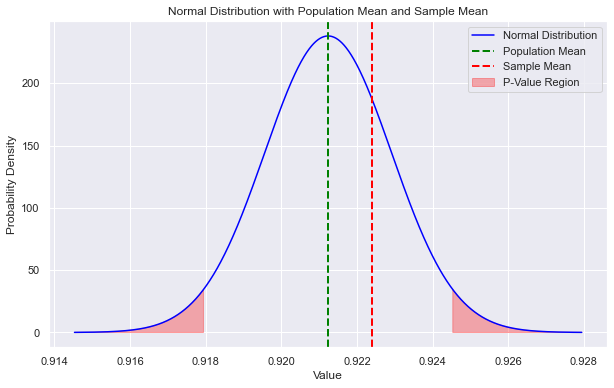

In [46]:
population_mean = cc_perc
alpha = 0.05

t_stat = (population_mean - sample_mean) / (sample_std / np.sqrt(sample_size))

p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))

x = np.linspace(population_mean - 4 * sample_std / np.sqrt(sample_size),
                population_mean + 4 * sample_std / np.sqrt(sample_size), 1000)

y = stats.norm.pdf(x, population_mean, sample_std / np.sqrt(sample_size))

plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
plt.plot(x, y, label='Normal Distribution', color='blue')

plt.axvline(population_mean, color='green', linestyle='dashed', linewidth=2, label='Population Mean')

plt.axvline(sample_mean, color='red', linestyle='dashed', linewidth=2, label='Sample Mean')

critical_value_low = population_mean + stats.t.ppf(alpha / 2, df=sample_size - 1) * (sample_std / np.sqrt(sample_size))
critical_value_high = population_mean + stats.t.ppf(1 - alpha / 2, df=sample_size - 1) * (
        sample_std / np.sqrt(sample_size))

plt.fill_between(x, y, where=(x <= critical_value_low) | (x >= critical_value_high), color='red', alpha=0.3,
                 label='P-Value Region')

plt.title('Normal Distribution with Population Mean and Sample Mean')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
df1.drop(columns='p_lefty_b_lefty', inplace=True)

In [48]:
#lhp > rhb
p1 = cc_perc  # Proportion of correct calls for all pitches
p2 =  pl_br_cc_percent / 100
N1 = len(df1)  # Total number of pitches for all situations
N2 = n

# Calculate pooled proportion
P_pooled = (p1 * N1 + p2 * N2) / (N1 + N2)

# Calculate the standard error
SE = np.sqrt(P_pooled * (1 - P_pooled) * (1/N1 + 1/N2))

# Calculate Z-statistic
Z = (p1 - p2) / SE

# Calculate the p-value
p_value = 2 * (1 - norm.cdf(abs(Z)))  # Two-tailed test

print("For left handed pitchers to right handed batters: ")

print("Z-Score: ", Z, ", P-Value: ", p_value)

print('Fail to reject H0')

For left handed pitchers to right handed batters: 
Z-Score:  1.763561925826551 , P-Value:  0.07780576270340922
Fail to reject H0


In [49]:
df1['p_lefty_b_righty'] = 0
df1.loc[(df1["pitches_lefty"] == 1) & (df1["bats_lefty"] == 0), "p_lefty_b_righty"] = 1

In [50]:
sample_mean = df1[df1["p_lefty_b_righty"] == 1]["correct_call"].mean()
sample_std = np.sqrt(sample_mean * (1 - sample_mean))
sample_size = len(df1[df1["p_lefty_b_righty"] == 1])

print(f"Sample Mean (Proportion of 1s): {sample_mean}")
print(f"Sample Standard Deviation: {sample_std}")
print(f"Sample Size: {sample_size}")

Sample Mean (Proportion of 1s): 0.9192703887086677
Sample Standard Deviation: 0.27241942139297387
Sample Size: 70284


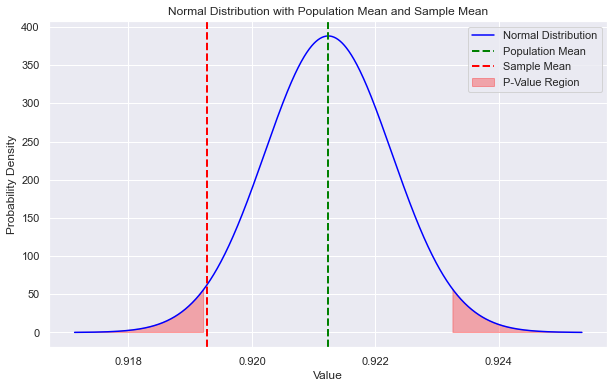

In [51]:
population_mean = cc_perc
alpha = 0.05

t_stat = (population_mean - sample_mean) / (sample_std / np.sqrt(sample_size))

p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))

x = np.linspace(population_mean - 4 * sample_std / np.sqrt(sample_size),
                population_mean + 4 * sample_std / np.sqrt(sample_size), 1000)

y = stats.norm.pdf(x, population_mean, sample_std / np.sqrt(sample_size))

plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
plt.plot(x, y, label='Normal Distribution', color='blue')

plt.axvline(population_mean, color='green', linestyle='dashed', linewidth=2, label='Population Mean')

plt.axvline(sample_mean, color='red', linestyle='dashed', linewidth=2, label='Sample Mean')

critical_value_low = population_mean + stats.t.ppf(alpha / 2, df=sample_size - 1) * (sample_std / np.sqrt(sample_size))
critical_value_high = population_mean + stats.t.ppf(1 - alpha / 2, df=sample_size - 1) * (
        sample_std / np.sqrt(sample_size))

plt.fill_between(x, y, where=(x <= critical_value_low) | (x >= critical_value_high), color='red', alpha=0.3,
                 label='P-Value Region')

plt.title('Normal Distribution with Population Mean and Sample Mean')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
df1.drop(columns='p_lefty_b_righty', inplace=True)

In [53]:
#rhp > lhb
p1 = cc_perc  # Proportion of correct calls for all pitches
p2 =  pr_bl_cc_percent / 100
N1 = len(df1)  # Total number of pitches for all situations
N2 = b

# Calculate pooled proportion
P_pooled = (p1 * N1 + p2 * N2) / (N1 + N2)

# Calculate the standard error
SE = np.sqrt(P_pooled * (1 - P_pooled) * (1/N1 + 1/N2))

# Calculate Z-statistic
Z = (p1 - p2) / SE

# Calculate the p-value
p_value = 2 * (1 - norm.cdf(abs(Z)))  # Two-tailed test

print("For right handed pitchers to left handed batters: ")

print("Z-Score: ", Z, ", P-Value: ", p_value)

print('Fail to reject H0')

For right handed pitchers to left handed batters: 
Z-Score:  -1.1440861617684432 , P-Value:  0.25258790602574077
Fail to reject H0


In [54]:
df1['p_righty_b_lefty'] = 0
df1.loc[(df1["pitches_lefty"] == 0) & (df1["bats_lefty"] == 1), "p_righty_b_lefty"] = 1

In [55]:
sample_mean = df1[df1["p_righty_b_lefty"] == 1]["correct_call"].mean()
sample_std = np.sqrt(sample_mean * (1 - sample_mean))
sample_size = len(df1[df1["p_righty_b_lefty"] == 1])

print(f"Sample Mean (Proportion of 1s): {sample_mean}")
print(f"Sample Standard Deviation: {sample_std}")
print(f"Sample Size: {sample_size}")

Sample Mean (Proportion of 1s): 0.9222741962918863
Sample Standard Deviation: 0.2677396181853583
Sample Size: 117580


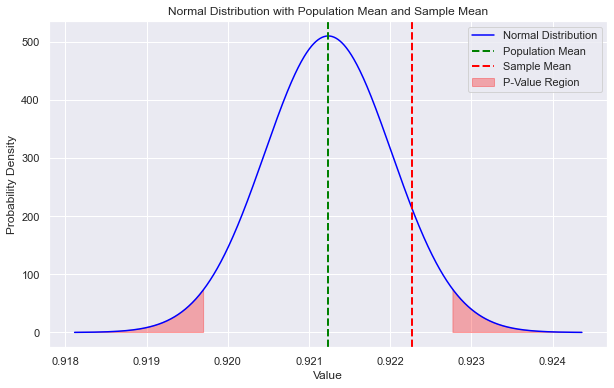

In [56]:
population_mean = cc_perc
alpha = 0.05

t_stat = (population_mean - sample_mean) / (sample_std / np.sqrt(sample_size))

p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))

x = np.linspace(population_mean - 4 * sample_std / np.sqrt(sample_size),
                population_mean + 4 * sample_std / np.sqrt(sample_size), 1000)

y = stats.norm.pdf(x, population_mean, sample_std / np.sqrt(sample_size))

plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
plt.plot(x, y, label='Normal Distribution', color='blue')

plt.axvline(population_mean, color='green', linestyle='dashed', linewidth=2, label='Population Mean')

plt.axvline(sample_mean, color='red', linestyle='dashed', linewidth=2, label='Sample Mean')

critical_value_low = population_mean + stats.t.ppf(alpha / 2, df=sample_size - 1) * (sample_std / np.sqrt(sample_size))
critical_value_high = population_mean + stats.t.ppf(1 - alpha / 2, df=sample_size - 1) * (
        sample_std / np.sqrt(sample_size))

plt.fill_between(x, y, where=(x <= critical_value_low) | (x >= critical_value_high), color='red', alpha=0.3,
                 label='P-Value Region')

plt.title('Normal Distribution with Population Mean and Sample Mean')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
df1.drop(columns='p_righty_b_lefty', inplace=True)

In [58]:
#rhp > rhb
p1 = cc_perc  # Proportion of correct calls for all pitches
p2 =  pr_br_cc_percent / 100
N1 = len(df1)  # Total number of pitches for all situations
N2 = d

# Calculate pooled proportion
P_pooled = (p1 * N1 + p2 * N2) / (N1 + N2)

# Calculate the standard error
SE = np.sqrt(P_pooled * (1 - P_pooled) * (1/N1 + 1/N2))

# Calculate Z-statistic
Z = (p1 - p2) / SE

# Calculate the p-value
p_value = 2 * (1 - norm.cdf(abs(Z)))  # Two-tailed test

print("For right handed pitchers to right handed batters: ")

print("Z-Score: ", Z, ", P-Value: ", p_value)

print('Fail to reject H0')

For right handed pitchers to right handed batters: 
Z-Score:  0.11208743192113302 , P-Value:  0.9107540825000895
Fail to reject H0


In [59]:
df1['p_righty_b_righty'] = 0
df1.loc[(df1["pitches_lefty"] == 0) & (df1["bats_lefty"] == 0), "p_righty_b_righty"] = 1

In [60]:
sample_mean = df1[df1["p_righty_b_righty"] == 1]["correct_call"].mean()
sample_std = np.sqrt(sample_mean * (1 - sample_mean))
sample_size = len(df1[df1["p_righty_b_righty"] == 1])

print(f"Sample Mean (Proportion of 1s): {sample_mean}")
print(f"Sample Standard Deviation: {sample_std}")
print(f"Sample Size: {sample_size}")

Sample Mean (Proportion of 1s): 0.9211412201807514
Sample Standard Deviation: 0.26951822325154173
Sample Size: 137537


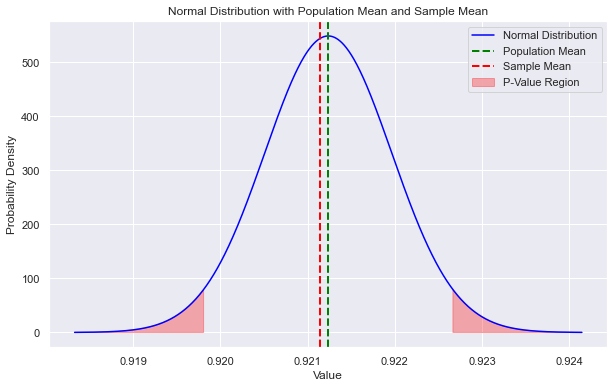

In [61]:
population_mean = cc_perc
alpha = 0.05

t_stat = (population_mean - sample_mean) / (sample_std / np.sqrt(sample_size))

p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))

x = np.linspace(population_mean - 4 * sample_std / np.sqrt(sample_size),
                population_mean + 4 * sample_std / np.sqrt(sample_size), 1000)

y = stats.norm.pdf(x, population_mean, sample_std / np.sqrt(sample_size))

plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
plt.plot(x, y, label='Normal Distribution', color='blue')

plt.axvline(population_mean, color='green', linestyle='dashed', linewidth=2, label='Population Mean')

plt.axvline(sample_mean, color='red', linestyle='dashed', linewidth=2, label='Sample Mean')

critical_value_low = population_mean + stats.t.ppf(alpha / 2, df=sample_size - 1) * (sample_std / np.sqrt(sample_size))
critical_value_high = population_mean + stats.t.ppf(1 - alpha / 2, df=sample_size - 1) * (
        sample_std / np.sqrt(sample_size))

plt.fill_between(x, y, where=(x <= critical_value_low) | (x >= critical_value_high), color='red', alpha=0.3,
                 label='P-Value Region')

plt.title('Normal Distribution with Population Mean and Sample Mean')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
df1.drop(columns='p_righty_b_righty', inplace=True)

Our a/b testing tells us that we cannot reject the null hypothesis (regardless of pitcher / batter handedness) that there is no association between handedness and correct call percentage

Now we will examine pitch type on the ability of the umpire to make the correct determination

- CH: changeup
- CS, CU: curveball
- EP: eephus
- FA, FF: four-seam fastball
- FC: cutter
- FS: splitter
- KC: knuckle-curve
- KN: knuckle-ball
- SI: sinker
- SL: slider

In order to make things easier, we will bucket the pitchtypes into three different categories: Fastballs, Breaking Balls and Offspeed

FB
- FA, FF, SI

BB
- SL, FC, CU + CS, KC,

OS
-  CH, FS, KN, EP

In [63]:
df1['FB'] = 0
df1['BB'] = 0
df1['OS'] = 0

In [64]:
df1.loc[df1["pitch_type"].isin([ 'FA', 'FF', 'SI']), "FB"] = 1
df1.loc[df1["pitch_type"].isin([ 'SL', 'FC', 'CU', 'CS', 'KC']), "BB"] = 1
df1.loc[df1["pitch_type"].isin([ 'CH', 'FS', 'KN', 'EP']), "OS"] = 1

In [65]:
df1["FB_correct_call"] = 0
df1["BB_correct_call"] = 0
df1["OS_correct_call"] = 0


df1.loc[(df1["FB"] == 1) & (df1["correct_call"] == 1), "FB_correct_call"] = 1
df1.loc[(df1["BB"] == 1) & (df1["correct_call"] == 1), "BB_correct_call"] = 1
df1.loc[(df1["OS"] == 1) & (df1["correct_call"] == 1), "OS_correct_call"] = 1

In [66]:
# if a pitch is a fb, what is the liklihood that it was called correctly

#sum of pitch type called correctly / total sum of pitch type

fb_cc_perc = df1["FB_correct_call"].sum() / df1["FB"].sum() * 100
bb_cc_perc = df1["BB_correct_call"].sum() / df1["BB"].sum() * 100
os_cc_perc = df1["OS_correct_call"].sum() / df1["OS"].sum() * 100

print("Fastball correct call percentage: ", fb_cc_perc)
print("Breaking ball correct call percentage: ",bb_cc_perc)
print("Off speed correct call percentage: ",os_cc_perc)

Fastball correct call percentage:  91.29555451935664
Breaking ball correct call percentage:  92.57573355677846
Off speed correct call percentage:  94.29094870271341


In [67]:
#fb
p1 = cc_perc  # Proportion of correct calls for all pitches
p2 =  fb_cc_perc / 100
N1 = len(df1)  # Total number of pitches for all situations
N2 = df1["FB"].sum()

# Calculate pooled proportion
P_pooled = (p1 * N1 + p2 * N2) / (N1 + N2)

# Calculate the standard error
SE = np.sqrt(P_pooled * (1 - P_pooled) * (1/N1 + 1/N2))

# Calculate Z-statistic
Z = (p1 - p2) / SE

# Calculate the p-value
p_value = 2 * (1 - norm.cdf(abs(Z)))  # Two-tailed test

print("Z-score: ", Z,"P-value: ", p_value)
print("Total Pitches overall: ", N1,", Total Fastballs: ", N2)

print('Reject H0')

Z-score:  10.398961388134925 P-value:  0.0
Total Pitches overall:  350864 , Total Fastballs:  178001
Reject H0


In [68]:
sample_mean = df1[df1["FB"] == 1]["correct_call"].mean()
sample_std = np.sqrt(sample_mean * (1 - sample_mean))
sample_size = len(df1[df1["FB"] == 1])

print(f"Sample Mean (Proportion of 1s): {sample_mean}")
print(f"Sample Standard Deviation: {sample_std}")
print(f"Sample Size: {sample_size}")

Sample Mean (Proportion of 1s): 0.9129555451935664
Sample Standard Deviation: 0.2819001910142744
Sample Size: 178001


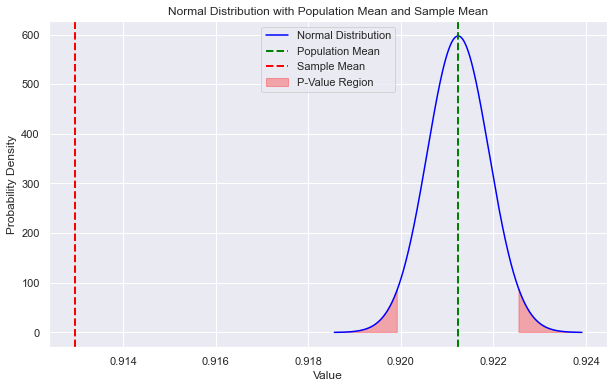

In [69]:
population_mean = cc_perc
alpha = 0.05

t_stat = (population_mean - sample_mean) / (sample_std / np.sqrt(sample_size))

p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))

x = np.linspace(population_mean - 4 * sample_std / np.sqrt(sample_size),
                population_mean + 4 * sample_std / np.sqrt(sample_size), 1000)

y = stats.norm.pdf(x, population_mean, sample_std / np.sqrt(sample_size))

plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
plt.plot(x, y, label='Normal Distribution', color='blue')

plt.axvline(population_mean, color='green', linestyle='dashed', linewidth=2, label='Population Mean')

plt.axvline(sample_mean, color='red', linestyle='dashed', linewidth=2, label='Sample Mean')

critical_value_low = population_mean + stats.t.ppf(alpha / 2, df=sample_size - 1) * (sample_std / np.sqrt(sample_size))
critical_value_high = population_mean + stats.t.ppf(1 - alpha / 2, df=sample_size - 1) * (
        sample_std / np.sqrt(sample_size))

plt.fill_between(x, y, where=(x <= critical_value_low) | (x >= critical_value_high), color='red', alpha=0.3,
                 label='P-Value Region')

plt.title('Normal Distribution with Population Mean and Sample Mean')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
p1 = cc_perc  # Proportion of correct calls for all pitches
p2 =  bb_cc_perc / 100
N1 = len(df1)  # Total number of pitches for all situations
N2 = df1["BB"].sum()

# Calculate pooled proportion
P_pooled = (p1 * N1 + p2 * N2) / (N1 + N2)

# Calculate the standard error
SE = np.sqrt(P_pooled * (1 - P_pooled) * (1/N1 + 1/N2))

# Calculate Z-statistic
Z = (p1 - p2) / SE

# Calculate the p-value
p_value = 2 * (1 - norm.cdf(abs(Z)))  # Two-tailed test

print("Z-score: ", Z,"P-value: ", p_value)
print("Total Pitches overall: ", N1,", Total Breaking Balls: ", N2)

print('Reject H0')

Z-score:  -5.241472994837807 P-value:  1.5929979380047143e-07
Total Pitches overall:  350864 , Total Breaking Balls:  132471
Reject H0


In [71]:
sample_mean = df1[df1["BB"] == 1]["correct_call"].mean()
sample_std = np.sqrt(sample_mean * (1 - sample_mean))
sample_size = len(df1[df1["BB"] == 1])

print(f"Sample Mean (Proportion of 1s): {sample_mean}")
print(f"Sample Standard Deviation: {sample_std}")
print(f"Sample Size: {sample_size}")

Sample Mean (Proportion of 1s): 0.9257573355677846
Sample Standard Deviation: 0.262165389039478
Sample Size: 132471


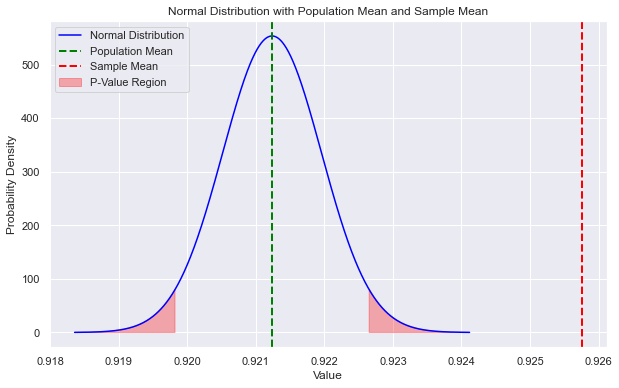

In [72]:
population_mean = cc_perc
alpha = 0.05

t_stat = (population_mean - sample_mean) / (sample_std / np.sqrt(sample_size))

p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))

x = np.linspace(population_mean - 4 * sample_std / np.sqrt(sample_size),
                population_mean + 4 * sample_std / np.sqrt(sample_size), 1000)

y = stats.norm.pdf(x, population_mean, sample_std / np.sqrt(sample_size))

plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
plt.plot(x, y, label='Normal Distribution', color='blue')

plt.axvline(population_mean, color='green', linestyle='dashed', linewidth=2, label='Population Mean')

plt.axvline(sample_mean, color='red', linestyle='dashed', linewidth=2, label='Sample Mean')

critical_value_low = population_mean + stats.t.ppf(alpha / 2, df=sample_size - 1) * (sample_std / np.sqrt(sample_size))
critical_value_high = population_mean + stats.t.ppf(1 - alpha / 2, df=sample_size - 1) * (
        sample_std / np.sqrt(sample_size))

plt.fill_between(x, y, where=(x <= critical_value_low) | (x >= critical_value_high), color='red', alpha=0.3,
                 label='P-Value Region')

plt.title('Normal Distribution with Population Mean and Sample Mean')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [73]:
p1 = cc_perc  # Proportion of correct calls for all pitches
p2 =  os_cc_perc / 100
N1 = len(df1)  # Total number of pitches for all situations
N2 = df1["OS"].sum()

# Calculate pooled proportion
P_pooled = (p1 * N1 + p2 * N2) / (N1 + N2)

# Calculate the standard error
SE = np.sqrt(P_pooled * (1 - P_pooled) * (1/N1 + 1/N2))

# Calculate Z-statistic
Z = (p1 - p2) / SE

# Calculate the p-value
p_value = 2 * (1 - norm.cdf(abs(Z)))  # Two-tailed test

print("Z-score: ", Z,"P-value: ", p_value)
print("Total Pitches overall: ", N1,", Total Off speed: ", N2)

print('Reject H0')

Z-score:  -15.515808568871536 P-value:  0.0
Total Pitches overall:  350864 , Total Off speed:  40392
Reject H0


In [74]:
sample_mean = df1[df1["OS"] == 1]["correct_call"].mean()
sample_std = np.sqrt(sample_mean * (1 - sample_mean))
sample_size = len(df1[df1["OS"] == 1])

print(f"Sample Mean (Proportion of 1s): {sample_mean}")
print(f"Sample Standard Deviation: {sample_std}")
print(f"Sample Size: {sample_size}")

Sample Mean (Proportion of 1s): 0.9429094870271341
Sample Standard Deviation: 0.2320154872015249
Sample Size: 40392


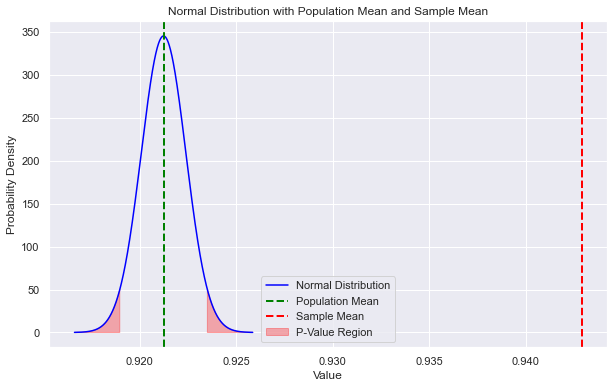

In [75]:
population_mean = cc_perc
alpha = 0.05

t_stat = (population_mean - sample_mean) / (sample_std / np.sqrt(sample_size))

p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))

x = np.linspace(population_mean - 4 * sample_std / np.sqrt(sample_size),
                population_mean + 4 * sample_std / np.sqrt(sample_size), 1000)

y = stats.norm.pdf(x, population_mean, sample_std / np.sqrt(sample_size))

plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
plt.plot(x, y, label='Normal Distribution', color='blue')

plt.axvline(population_mean, color='green', linestyle='dashed', linewidth=2, label='Population Mean')

plt.axvline(sample_mean, color='red', linestyle='dashed', linewidth=2, label='Sample Mean')

critical_value_low = population_mean + stats.t.ppf(alpha / 2, df=sample_size - 1) * (sample_std / np.sqrt(sample_size))
critical_value_high = population_mean + stats.t.ppf(1 - alpha / 2, df=sample_size - 1) * (
        sample_std / np.sqrt(sample_size))

plt.fill_between(x, y, where=(x <= critical_value_low) | (x >= critical_value_high), color='red', alpha=0.3,
                 label='P-Value Region')

plt.title('Normal Distribution with Population Mean and Sample Mean')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

After analysis, we reject the null hypothesis and find that the type of pitch is statistically significant in determining correct call percentage for each pitch type.

##### No buckets for pitch type

In [76]:
counts_by_pitch_type = df1.groupby(['pitch_type', 'correct_call']).size().unstack(fill_value=0)
total_calls_by_pitch_type = counts_by_pitch_type.sum(axis=1)
correct_calls_by_pitch_type = counts_by_pitch_type.get(1,0)
incorrect_calls_by_pitch_type = counts_by_pitch_type.get(0,0)

percentage_correct_calls_by_pitch_type = (correct_calls_by_pitch_type / total_calls_by_pitch_type) * 100
percentage_incorrect_calls_by_pitch_type = (incorrect_calls_by_pitch_type / total_calls_by_pitch_type) * 100

percentages_matrix_by_pitch_type = pd.DataFrame({
    'Percentage Correct' : percentage_correct_calls_by_pitch_type, 
    'Percentage Incorrect' : percentage_incorrect_calls_by_pitch_type
}).reset_index()

percentages_matrix_by_pitch_type

,pitch_type,Percentage Correct,Percentage Incorrect
0,CH,94.308717,5.691283
1,CS,92.307692,7.692308
2,CU,92.721031,7.278969
3,EP,87.665198,12.334802
4,FA,91.330344,8.669656
5,FC,91.420143,8.579857
6,FF,91.456158,8.543842
7,FS,94.507622,5.492378
8,KC,92.692251,7.307749
9,KN,91.666667,8.333333


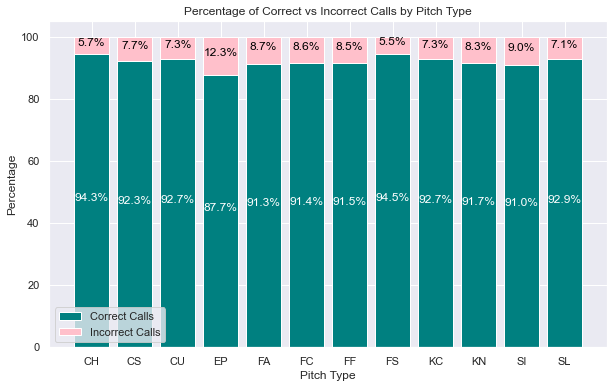

In [77]:
pitch_types = percentages_matrix_by_pitch_type['pitch_type']
percentage_correct = percentages_matrix_by_pitch_type['Percentage Correct']
percentage_incorrect = percentages_matrix_by_pitch_type['Percentage Incorrect']

plt.figure(figsize=(10, 6))
plt.bar(pitch_types, percentage_correct, color='teal', label='Correct Calls')
plt.bar(pitch_types, percentage_incorrect, bottom=percentage_correct, color='pink', label='Incorrect Calls')

sns.set_theme(style="darkgrid")

plt.xlabel('Pitch Type')
plt.ylabel('Percentage')
plt.title('Percentage of Correct vs Incorrect Calls by Pitch Type')
plt.legend()

for index, value in enumerate(pitch_types):
    plt.text(index, percentage_correct[index] / 2, f'{percentage_correct[index]:.1f}%', ha='center', color='white')
    plt.text(index, percentage_correct[index] + percentage_incorrect[index] / 2, f'{percentage_incorrect[index]:.1f}%', ha='center', color='black')

plt.show()

##### Buckets for pitch type

In [78]:
pitch_type_map = {
    'FA': 'FB', 'FF': 'FB', 'SI': 'FB',  # Fastballs
    'SL': 'BB', 'FC': 'BB', 'CU': 'BB', 'CS': 'BB', 'KC': 'BB',  # Breaking Balls
    'CH': 'OS', 'FS': 'OS', 'KN': 'OS', 'EP': 'OS'  # Off speed
}

df1['pitch_group'] = df1['pitch_type'].map(pitch_type_map)

counts_by_pitch_group = df1.groupby(['pitch_group', 'correct_call']).size().unstack(fill_value=0)
total_calls_by_pitch_group = counts_by_pitch_group.sum(axis=1)
correct_calls_by_pitch_group = counts_by_pitch_group.get(1, 0)
incorrect_calls_by_pitch_group = counts_by_pitch_group.get(0, 0)

percentage_correct_calls_by_pitch_group = (correct_calls_by_pitch_group / total_calls_by_pitch_group) * 100
percentage_incorrect_calls_by_pitch_group = (incorrect_calls_by_pitch_group / total_calls_by_pitch_group) * 100

percentages_matrix_by_pitch_group = pd.DataFrame({
    'Pitch Group': total_calls_by_pitch_group.index,
    'Percentage Correct': percentage_correct_calls_by_pitch_group,
    'Percentage Incorrect': percentage_incorrect_calls_by_pitch_group
}).reset_index(drop=True)

percentages_matrix_by_pitch_group

,Pitch Group,Percentage Correct,Percentage Incorrect
0,BB,92.575734,7.424266
1,FB,91.295555,8.704445
2,OS,94.290949,5.709051


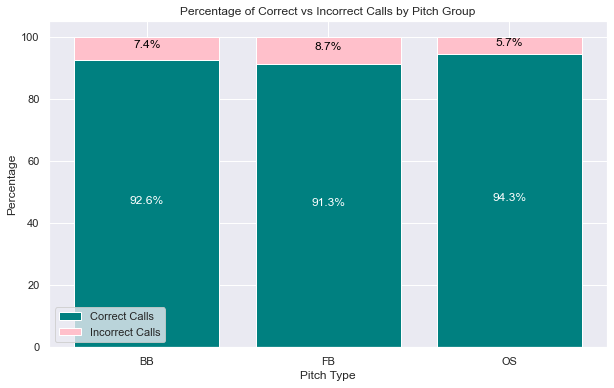

In [79]:
pitch_types = percentages_matrix_by_pitch_group['Pitch Group']
percentage_correct = percentages_matrix_by_pitch_group['Percentage Correct']
percentage_incorrect = percentages_matrix_by_pitch_group['Percentage Incorrect']

plt.figure(figsize=(10, 6))
plt.bar(pitch_types, percentage_correct, color='teal', label='Correct Calls')
plt.bar(pitch_types, percentage_incorrect, bottom=percentage_correct, color='pink', label='Incorrect Calls')

plt.xlabel('Pitch Type')
plt.ylabel('Percentage')
plt.title('Percentage of Correct vs Incorrect Calls by Pitch Group')
plt.legend(loc = 'lower left')

for index, value in enumerate(pitch_types):
    plt.text(index, percentage_correct[index] / 2, f'{percentage_correct[index]:.1f}%', ha='center', color='white')
    plt.text(index, percentage_correct[index] + percentage_incorrect[index] / 2, f'{percentage_incorrect[index]:.1f}%', ha='center', color='black')

plt.show()

Does the Pitch Number have an effect on the call of the umpire?

In [80]:
pitch_one_cc = 0
for index, row in df1.iterrows():
    if row['pitch_number'] == 1:
        pitch_one_cc += row['correct_call']

print(pitch_one_cc)
print(df['pitch_number'].value_counts())

pitch_two_cc = 0
for index, row in df1.iterrows():
    if row['pitch_number'] == 2:
        pitch_two_cc += row['correct_call']


111070
pitch_number
1     121920
2      82560
3      61477
4      43724
5      24189
6      10647
7       4164
8       1522
9        567
10       175
11        87
12        17
13         9
14         2
15         1
16         1
Name: count, dtype: int64


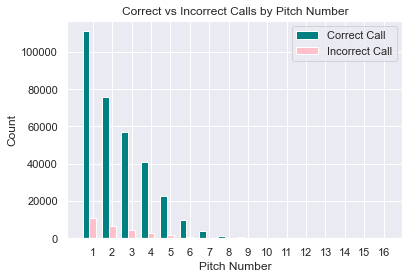

In [81]:
counts = df1.groupby(['pitch_number', 'correct_call']).size().unstack(fill_value=0)

bar_width = 0.35
pitch_numbers = counts.index
correct_calls =  counts[1]
incorrect_calls = counts[0]

plt.bar(pitch_numbers, correct_calls, width=bar_width, label='Correct Call', color='teal')
plt.bar(pitch_numbers + bar_width, incorrect_calls, width=bar_width, label='Incorrect Call', color='pink')

plt.xlabel('Pitch Number')
plt.ylabel('Count')
plt.title('Correct vs Incorrect Calls by Pitch Number')
plt.legend()

plt.xticks(pitch_numbers + bar_width, ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'])


plt.show()


The amount of data significantly diminishes as we go down the pitch number. We may have to decide whether or not we want to keep these rows or not. 

In [82]:
df_filtered = df1[df1['pitch_number'] <= 9]
counts = df_filtered.groupby(['pitch_number', 'correct_call']).size().unstack(fill_value=0)
total_calls = counts.sum(axis=1)
correct_calls = counts[1]
incorrect_calls = counts[0]

percentage_correct_calls = (correct_calls / total_calls) * 100
percentage_incorrect_calls = (incorrect_calls / total_calls)  * 100

percentages_matrix = pd.DataFrame({
    'Percetage Correct' : percentage_correct_calls,
    'Percentage Incorrect' : percentage_incorrect_calls
})

percentages_matrix

,Percetage Correct,Percentage Incorrect
pitch_number,,
1,91.151561,8.848439
2,91.808464,8.191536
3,92.802161,7.197839
4,93.405940,6.594060
5,93.244250,6.755750
6,93.098260,6.901740
7,93.554594,6.445406
8,93.491124,6.508876
9,94.003527,5.996473


Visualized as a percentage rather than count

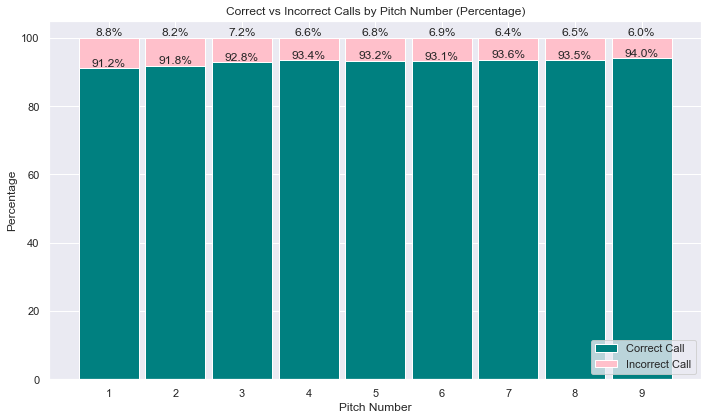

In [83]:
bar_width = 0.9  
pitch_numbers = counts.index

plt.figure(figsize=(10, 6))  
bars_correct = plt.bar(pitch_numbers, percentage_correct_calls, width=bar_width, label='Correct Call', color='teal')
bars_incorrect = plt.bar(pitch_numbers, percentage_incorrect_calls, width=bar_width, bottom=percentage_correct_calls, label='Incorrect Call', color='pink')

plt.xlabel('Pitch Number')
plt.ylabel('Percentage')  
plt.title('Correct vs Incorrect Calls by Pitch Number (Percentage)')
plt.legend(loc = 'lower right')

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.1f}%', ha='center', va='bottom')

add_labels(bars_correct)

for bar in bars_incorrect:
    y_val = bar.get_y() + bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., y_val, f'{bar.get_height():.1f}%', ha='center', va='bottom')

plt.xticks(pitch_numbers, pitch_numbers) 

plt.tight_layout()  
plt.show()

Plot with graphs side by side

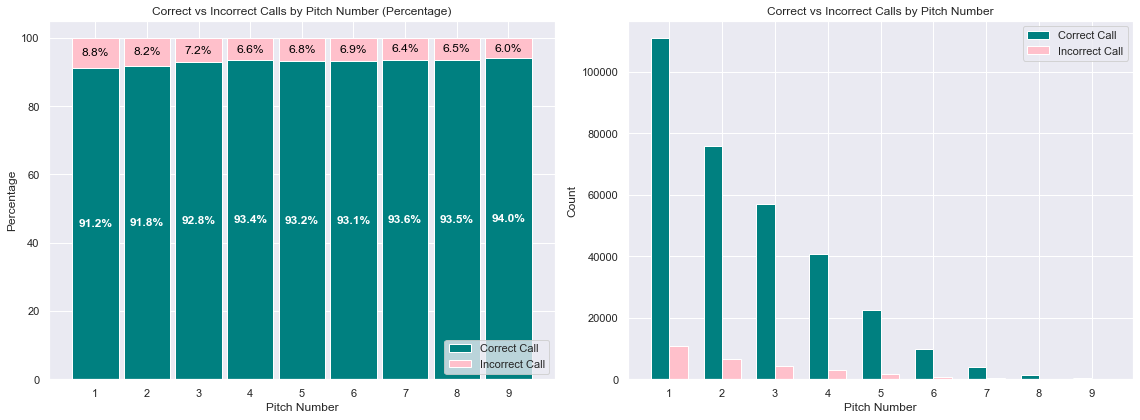

In [84]:
counts = df1.groupby(['pitch_number', 'correct_call']).size().unstack(fill_value=0)

correct_calls = counts.reindex(pitch_numbers, fill_value=0)[1]
incorrect_calls = counts.reindex(pitch_numbers, fill_value=0)[0]

bar_width = 0.35  

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First plot (percentage)
bars_correct = axes[0].bar(pitch_numbers, percentage_correct_calls, width=0.9, label='Correct Call', color='teal')
bars_incorrect = axes[0].bar(pitch_numbers, percentage_incorrect_calls, width=0.9, bottom=percentage_correct_calls, label='Incorrect Call', color='pink')

axes[0].set_xlabel('Pitch Number')
axes[0].set_ylabel('Percentage')
axes[0].set_title('Correct vs Incorrect Calls by Pitch Number (Percentage)')
axes[0].legend(loc='lower right')

def add_labels_inside(bars, ax):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2., bar.get_y() + height / 2, f'{height:.1f}%', ha='center', va='center', color='white', fontweight='bold')

add_labels_inside(bars_correct, axes[0])  
for bar in bars_incorrect:
    y_val = bar.get_y() + bar.get_height() / 2
    if bar.get_height() > 0:
        axes[0].text(bar.get_x() + bar.get_width() / 2., y_val, f'{bar.get_height():.1f}%', ha='center', va='center', color='black')#, fontweight='bold')

axes[0].set_xticks(pitch_numbers)
axes[0].set_xticklabels(pitch_numbers)

# Second plot (count)
axes[1].bar(pitch_numbers, correct_calls, width=bar_width, label='Correct Call', color='teal')
axes[1].bar(pitch_numbers + bar_width, incorrect_calls, width=bar_width, label='Incorrect Call', color='pink')

axes[1].set_xlabel('Pitch Number')
axes[1].set_ylabel('Count')
axes[1].set_title('Correct vs Incorrect Calls by Pitch Number')
axes[1].legend()

axes[1].set_xticks(pitch_numbers + bar_width / 2)
axes[1].set_xticklabels(pitch_numbers)

plt.tight_layout()
plt.show()

Interesting how umpire accuracy improves as a the pitch number increases. 

In [85]:
occurrences_by_pitch_number = df1[df1['pitch_number'] <= 9].groupby('pitch_number')[['FB', 'BB', 'OS']].sum()
occurrences_by_pitch_number['Total'] = occurrences_by_pitch_number.sum(axis=1)

occurrences_by_pitch_number['FB_percentage'] = (occurrences_by_pitch_number['FB'] / occurrences_by_pitch_number['Total'])  * 100
occurrences_by_pitch_number['BB_percentage'] = (occurrences_by_pitch_number['BB'] / occurrences_by_pitch_number['Total'])  * 100
occurrences_by_pitch_number['OS_percentage'] = (occurrences_by_pitch_number['OS'] / occurrences_by_pitch_number['Total'])  * 100

print(occurrences_by_pitch_number)


                 FB     BB     OS   Total  FB_percentage  BB_percentage  \
pitch_number                                                              
1             64437  48500   8915  121852      52.881364      39.802383   
2             39452  31059  12001   82512      47.813651      37.641798   
3             29598  23138   8713   61449      48.166772      37.653989   
4             23253  15046   5407   43706      53.203222      34.425479   
5             12452   8649   3071   24172      51.514149      35.781069   
6              5378   3820   1437   10635      50.568876      35.919135   
7              2178   1432    548    4158      52.380952      34.439634   
8               804    530    187    1521      52.859961      34.845496   
9               304    191     72     567      53.615520      33.686067   

              OS_percentage  
pitch_number                 
1                  7.316253  
2                 14.544551  
3                 14.179238  
4                 12.371

Here we can see the percentage breakdown of each pitch number by pitch type. We can see it is rare for the first pitch to be off speed, but the second pitch is twice as likely to be off speed. The second and third pitches are the only scenarios where it is more likely for the pitcher to deliver a changeup than a fast ball.  

In [86]:
correct_call_percentage = df1.groupby(['balls', 'strikes'])['correct_call'].mean() * 100

print(correct_call_percentage)

balls  strikes
0      0          91.151561
       1          92.774803
       2          96.195164
1      0          90.700760
       1          92.193056
       2          95.273698
2      0          89.771507
       1          91.257566
       2          94.000218
3      0          91.068329
       1          90.374736
       2          92.259066
4      2          50.000000
Name: correct_call, dtype: float64


Small error in the dataset, it is not possible to face a pitch when 4 balls have been delivered. Upon review of the game footage for these pitches, it was in fact 3-2. The data was simply entered incorrectly. 

In [87]:
df1['balls'] = df1['balls'].replace(4, 3)


This code will correct that error

In [88]:
correct_call_percentage = df1.groupby(['balls', 'strikes'])['correct_call'].mean() * 100

print(correct_call_percentage)

balls  strikes
0      0          91.151561
       1          92.774803
       2          96.195164
1      0          90.700760
       1          92.193056
       2          95.273698
2      0          89.771507
       1          91.257566
       2          94.000218
3      0          91.068329
       1          90.374736
       2          92.249695
Name: correct_call, dtype: float64


### Future Options for Analysis

Do umpires calls get worse later in the game (correct call - y-axis, at bat number x-axis)

group by each pitcher/batter/catcher (separately) and measure cc% for each (make sure sample size is large enough)

prob called strike & prob called ball for each zone

pitch type (x-axis) discreet strike_called_strike (y-axis) ball_called_strike (y-axis)

P(CC) vs Strike-Count(x-axis)

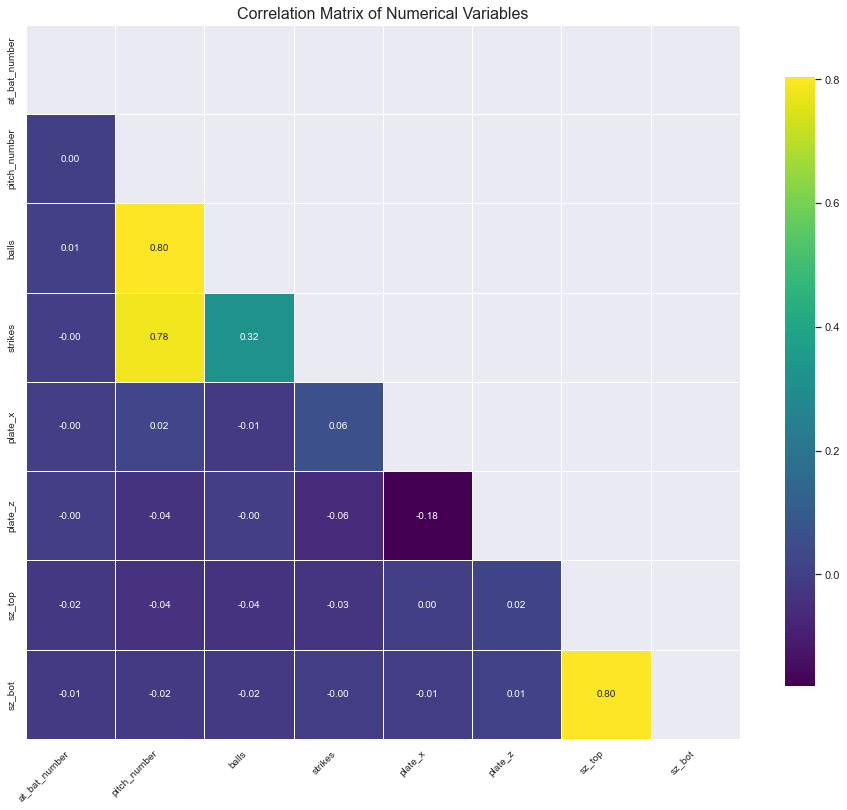

In [89]:
numerical_df = df1.select_dtypes(include=['number'])
numerical_df = numerical_df[['at_bat_number', 'pitch_number', 'balls', 'strikes', 'plate_x', 'plate_z', 'sz_top', 'sz_bot']]

corr_matrix = numerical_df.corr()

plt.figure(figsize=(16, 14))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='viridis',
            square=True, linewidths=.8, cbar_kws={"shrink": .8}, annot_kws={"size": 10})

plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotate the x labels for better fit and set font size
plt.yticks(fontsize=10)  # Set font size for y labels
plt.title('Correlation Matrix of Numerical Variables', fontsize=16)

plt.show()

In [90]:
df1.strikes

0         2
1         2
2         0
3         2
4         2
         ..
351057    0
351058    0
351059    0
351060    0
351061    0
Name: strikes, Length: 350864, dtype: int64

ONLY INCLUDED VARIABLES FROM FINAL MODEL

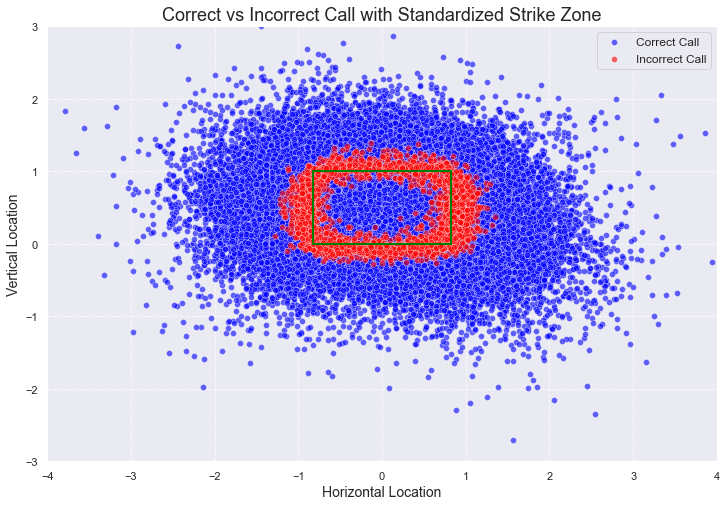

In [91]:
dfb = df1.copy()

dfb['normalized_z'] = (df1['plate_z'] - df1['sz_bot']) / (df1['sz_top'] - df1['sz_bot'])

dfb = dfb.sample(frac = 0.1, random_state=23)

correct_call = dfb[dfb['correct_call'] == 1]
incorrect_call = dfb[dfb['correct_call'] == 0]

sns.set_theme(style="darkgrid")

plt.figure(figsize=(12, 8))
sns.scatterplot(data=correct_call, x='plate_x', y='normalized_z', color='blue', alpha=0.6, label='Correct Call')
sns.scatterplot(data=incorrect_call, x='plate_x', y='normalized_z', color='red', alpha=0.6, label='Incorrect Call')

strike_zone = Rectangle((-0.83, 0), 1.66, 1, linewidth=2, edgecolor='green', facecolor='none')
plt.gca().add_patch(strike_zone)

plt.xlim(-4,4)
plt.ylim(-3,3)

plt.title('Correct vs Incorrect Call with Standardized Strike Zone', fontsize=18)
plt.xlabel('Horizontal Location', fontsize=14)
plt.ylabel('Vertical Location', fontsize=14)

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

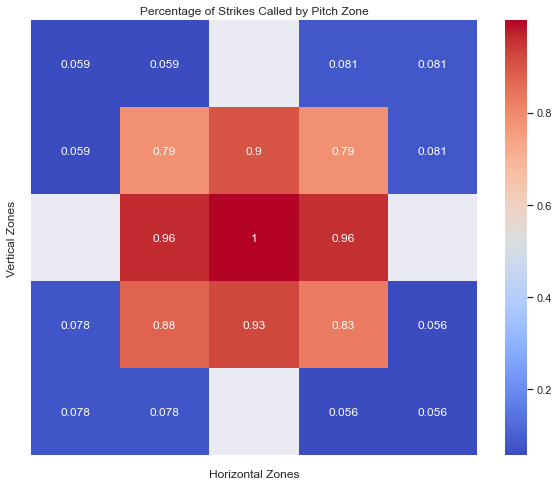

In [96]:
strike_percentage = df1.groupby('zone')['is_strike'].mean().reset_index()

strike_zone_matrix = np.full((5, 5), np.nan)  

strike_zone_matrix = np.full((5, 5), np.nan)  

zone_mapping = {
    1: (1, 1), 2: (1, 2), 3: (1, 3),
    4: (2, 1), 5: (2, 2), 6: (2, 3),
    7: (3, 1), 8: (3, 2), 9: (3, 3),
    11: [(0, 0), (0, 1), (1, 0)],  
    12: [(0, 3), (0, 4), (1, 4)],  
    13: [(3, 0), (4, 0), (4, 1)],  
    14: [(3, 4), (4, 3), (4, 4)]   
}

for _, row in strike_percentage.iterrows():
    zone = row['zone']
    percentage = row['is_strike']
    if zone in zone_mapping:
        if isinstance(zone_mapping[zone], list):  
            for pos in zone_mapping[zone]:
                strike_zone_matrix[pos] = percentage
        else:
            pos = zone_mapping[zone]
            strike_zone_matrix[pos] = percentage

mask = np.isnan(strike_zone_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(strike_zone_matrix, annot=True, cmap='coolwarm', cbar=True, mask=mask,
            xticklabels=['', '', '', '', ''], 
            yticklabels=['', '', '', '', ''])

plt.title('Percentage of Strikes Called by Pitch Zone')
plt.xlabel('Horizontal Zones')
plt.ylabel('Vertical Zones')
plt.show()

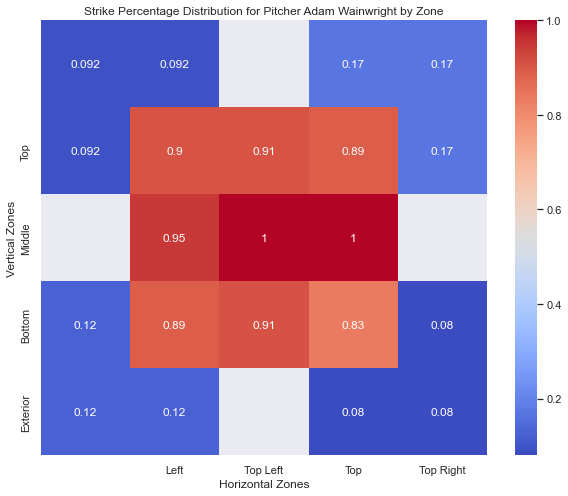

In [98]:
pitcher_strikes = df1.groupby('pitcher_id')['is_strike'].sum()
most_strikes_pitcher_id = pitcher_strikes.idxmax()

most_strikes_data = df1[df1['pitcher_id'] == most_strikes_pitcher_id]

strike_distribution = most_strikes_data.groupby('zone')['is_strike'].mean().reset_index()
strike_distribution.columns = ['zone', 'strike_percentage']
strike_distribution_matrix = np.full((5, 5), np.nan)

for _, row in strike_distribution.iterrows():
    zone = row['zone']
    percentage = row['strike_percentage']
    if zone in zone_mapping:
        if isinstance(zone_mapping[zone], list):
            for pos in zone_mapping[zone]:
                strike_distribution_matrix[pos] = percentage
        else:
            pos = zone_mapping[zone]
            strike_distribution_matrix[pos] = percentage

mask = np.isnan(strike_distribution_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(strike_distribution_matrix, annot=True, cmap='coolwarm', cbar=True, mask=mask,
            xticklabels=['', 'Left', 'Top Left', 'Top', 'Top Right'], 
            yticklabels=['', 'Top', 'Middle', 'Bottom', 'Exterior'])

plt.title(f'Strike Percentage Distribution for Pitcher Adam Wainwright by Zone')
plt.xlabel('Horizontal Zones')
plt.ylabel('Vertical Zones')
plt.show()

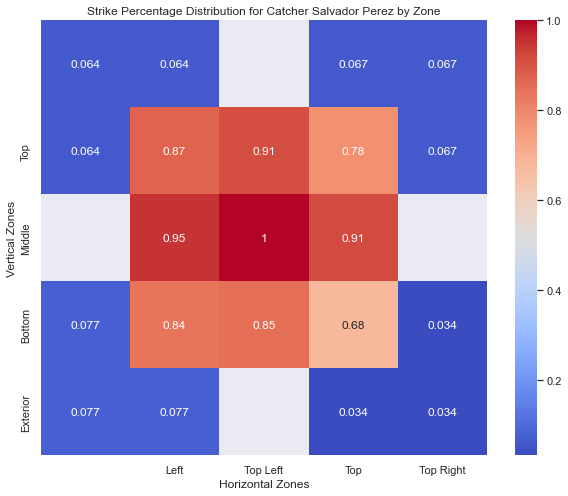

In [99]:
specific_catcher_data = df1[df1['catcher_id'] == "521692"]

strike_distribution = specific_catcher_data.groupby('zone')['is_strike'].mean().reset_index()
strike_distribution.columns = ['zone', 'strike_percentage']
strike_distribution_matrix = np.full((5, 5), np.nan)

for _, row in strike_distribution.iterrows():
    zone = row['zone']
    percentage = row['strike_percentage']
    if zone in zone_mapping:
        if isinstance(zone_mapping[zone], list):
            for pos in zone_mapping[zone]:
                strike_distribution_matrix[pos] = percentage
        else:
            pos = zone_mapping[zone]
            strike_distribution_matrix[pos] = percentage

mask = np.isnan(strike_distribution_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(strike_distribution_matrix, annot=True, cmap='coolwarm', cbar=True, mask=mask,
            xticklabels=['', 'Left', 'Top Left', 'Top', 'Top Right'], 
            yticklabels=['', 'Top', 'Middle', 'Bottom', 'Exterior'])

plt.title(f'Strike Percentage Distribution for Catcher Salvador Perez by Zone')
plt.xlabel('Horizontal Zones')
plt.ylabel('Vertical Zones')
plt.show()

## Algorithms We Intend to Apply: 

Since we are predicting whether or not a pitch will be called a strike (given that the batter doesn't swing), this is a **classification** task

The algorithms we plan on using for this task include: 

- Naive Model : True baseline with no machine learning ability
- Logistic Regression : this model is good to use because it is simple, easy to interpret, and provides a strong baseline for classification.
- XGBoost Classifier : this model is a good option to use because it is able to handle non-linear data, weigh feature importance, and resist overfitting.
- MLP Classifier : Multi-layer Perceptrons are a good option because it can model complex, non-linear relationships. Although it requires more data and computing power, it can provide better results. 

In [155]:
df1.columns

Index(['game_id', 'game_date', 'at_bat_number', 'pitch_number', 'pitch_type',
       'pitcher_id', 'batter_id', 'catcher_id', 'is_strike', 'zone', 'balls',
       'strikes', 'plate_x', 'plate_z', 'sz_top', 'sz_bot', 'broadcast',
       'bats_lefty', 'pitches_lefty', 'ball_called_ball', 'strike_called_ball',
       'ball_called_strike', 'strike_called_strike', 'correct_call',
       'p_lefty_correct_call', 'p_righty_correct_call',
       'b_righty_correct_call', 'b_lefty_correct_call', 'pl_bl_cc', 'pl_br_cc',
       'pr_br_cc', 'pr_bl_cc', 'FB', 'BB', 'OS', 'FB_correct_call',
       'BB_correct_call', 'OS_correct_call', 'pitch_group'],
      dtype='object')

### Dropping Columns that contain is_strike in calculation

In [156]:
df1.drop(columns=['broadcast', 'ball_called_ball', 'strike_called_ball', 'ball_called_strike', 'strike_called_strike', 'correct_call', 'p_lefty_correct_call', 'p_righty_correct_call', 'b_righty_correct_call', 'b_lefty_correct_call', 'pl_bl_cc', 'pl_br_cc', 'pr_br_cc', 'pr_bl_cc', 'FB_correct_call', 'BB_correct_call', 'OS_correct_call', 'game_date', 'FB', 'BB', 'OS', 'pitch_group'], inplace=True)

In [157]:
df1.zone = df1.zone.astype(str)

In [158]:
df1.head()

,game_id,at_bat_number,pitch_number,pitch_type,pitcher_id,batter_id,catcher_id,is_strike,zone,balls,strikes,plate_x,plate_z,sz_top,sz_bot,bats_lefty,pitches_lefty
0,662588,51,6,CH,605135,605137,543510,1,8,2,2,0.17,2.20,3.74,1.82,1,0
1,662588,51,5,FC,605135,605137,543510,0,11,1,2,-0.92,5.43,3.75,1.83,1,0
2,662588,51,1,SL,605135,605137,543510,0,14,0,0,0.86,1.28,3.51,1.58,1,0
3,662123,33,5,FF,607074,643265,663698,0,11,1,2,-0.15,5.07,3.58,1.85,0,1
4,663205,37,7,SL,605540,664023,605170,0,14,2,2,1.46,2.40,3.40,1.60,1,0


### Train Test Split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df1.drop(columns=['is_strike', ]), 
                                                    df1.is_strike,
                                                    test_size=0.3, 
                                                    stratify = df1.is_strike, 
                                                    random_state=23)

print(X_train.shape)

(245604, 16)


In [73]:
X_train.head()

,game_id,at_bat_number,pitch_number,pitch_type,pitcher_id,batter_id,catcher_id,zone,balls,strikes,plate_x,plate_z,sz_top,sz_bot,bats_lefty,pitches_lefty
204975,661421,10,1,FC,641154,666969,607732,14,0,0,1.47,1.62,3.10,1.48,0,0
206368,661872,38,5,FF,641329,666139,668939,12,2,2,0.56,4.34,3.57,1.71,1,0
67641,663350,51,1,FF,547001,677950,668721,11,0,0,-1.48,2.67,3.18,1.49,1,0
294199,662216,34,1,CH,674072,640492,669450,6,0,0,0.30,2.76,3.33,1.65,0,1
328405,661162,8,7,FF,543037,592669,543309,14,3,2,0.33,1.36,3.31,1.55,0,0


In [74]:
X_train.columns

Index(['game_id', 'at_bat_number', 'pitch_number', 'pitch_type', 'pitcher_id',
       'batter_id', 'catcher_id', 'zone', 'balls', 'strikes', 'plate_x',
       'plate_z', 'sz_top', 'sz_bot', 'bats_lefty', 'pitches_lefty'],
      dtype='object')

In [75]:
y_train.head()

204975    0
206368    0
67641     0
294199    1
328405    0
Name: is_strike, dtype: int64

In [76]:
X_train.columns

Index(['game_id', 'at_bat_number', 'pitch_number', 'pitch_type', 'pitcher_id',
       'batter_id', 'catcher_id', 'zone', 'balls', 'strikes', 'plate_x',
       'plate_z', 'sz_top', 'sz_bot', 'bats_lefty', 'pitches_lefty'],
      dtype='object')

In [77]:
X_train.dtypes

game_id           object
at_bat_number      int64
pitch_number       int64
pitch_type        object
pitcher_id        object
batter_id         object
catcher_id        object
zone              object
balls              int64
strikes            int64
plate_x          float64
plate_z          float64
sz_top           float64
sz_bot           float64
bats_lefty         int64
pitches_lefty      int64
dtype: object

### Pipeline

In [78]:
categorical_features = ['zone', 'game_id', 'pitch_type', 'pitcher_id', 'batter_id', 'catcher_id', 'bats_lefty', 'pitches_lefty'] #might want to add pitch_group
numerical_features = ['at_bat_number', 'pitch_number', 'balls', 'strikes', 'plate_x', 'plate_z', 'sz_top', 'sz_bot'] #might want to combine balls/striks into the form "balls-strikes" i.e. pitch count and change to categorical 

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' 
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

### Naive Model

In [108]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=23)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

dummy_clf.fit(X_train, y_train)

preds = dummy_clf.predict(X_test)

test_accuracy = accuracy_score(y_test, preds)
test_precision = precision_score(y_test, preds)
test_recall = recall_score(y_test, preds)
test_f1 = f1_score(y_test, preds)

print("Test set evaluation")
print("Accuracy: {:.2f}".format(test_accuracy))
print("Precision: {:.2f}".format(test_precision))
print("Recall: {:.2f}".format(test_recall))
print("F1: {:.2f}".format(test_f1))

Test set evaluation
Accuracy: 0.56
Precision: 0.33
Recall: 0.33
F1: 0.33


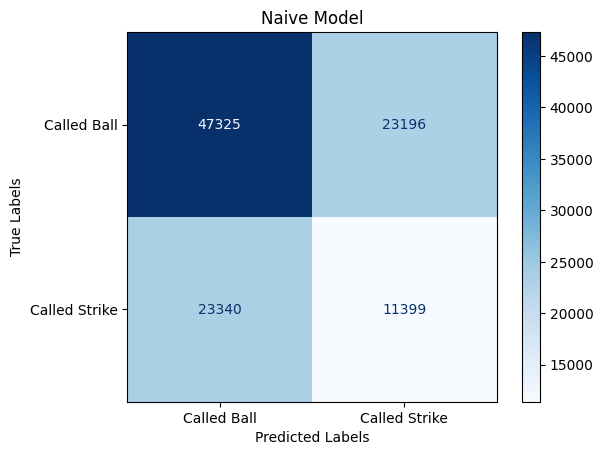

In [109]:
conf_matrix = confusion_matrix(y_test,preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["Called Ball", "Called Strike"])

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax) 

ax.set_title('Naive Model')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

In [110]:
report = classification_report(y_test, preds, target_names=['Called Ball', 'Called Strike'])
print("\nClassification Report:\n")
print(report)


Classification Report:

               precision    recall  f1-score   support

  Called Ball       0.67      0.67      0.67     70521
Called Strike       0.33      0.33      0.33     34739

     accuracy                           0.56    105260
    macro avg       0.50      0.50      0.50    105260
 weighted avg       0.56      0.56      0.56    105260



### Logistic Regression

To clarify, this is a classification model

In [74]:
logistic_reg = LogisticRegression(max_iter=200, solver='saga')

pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=23)),
    ('logistic_reg', logistic_reg)
])

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

pipeline_lr.fit(X_train, y_train)

preds = pipeline_lr.predict(X_test)

test_accuracy = accuracy_score(y_test, preds)
test_precision = precision_score(y_test, preds)
test_recall = recall_score(y_test, preds)
test_f1 = f1_score(y_test, preds)

print("Test set evaluation")
print("Accuracy: {:.2f}".format(test_accuracy))
print("Precision: {:.2f}".format(test_precision))
print("Recall: {:.2f}".format(test_recall))
print("F1: {:.2f}".format(test_f1))

Test set evaluation
Accuracy: 0.92
Precision: 0.89
Recall: 0.86
F1: 0.88


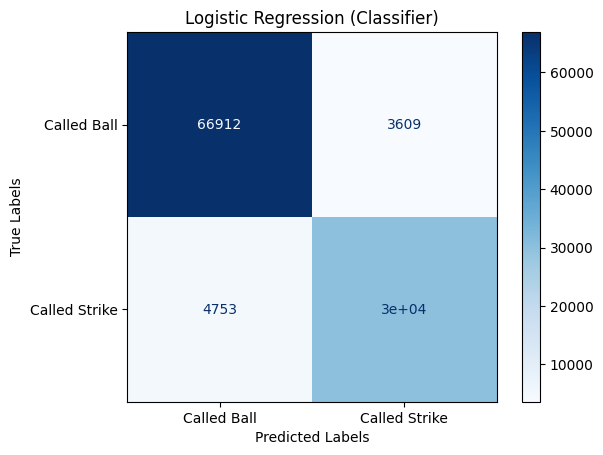

In [75]:
conf_matrix = confusion_matrix(y_test,preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["Called Ball", "Called Strike"])

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax) 

ax.set_title('Logistic Regression (Classifier)')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

In [93]:
report = classification_report(y_test, preds, target_names=['Called Ball', 'Called Strike'])
print("\nClassification Report:\n")
print(report)


Classification Report:

               precision    recall  f1-score   support

  Called Ball       0.93      0.95      0.94     70521
Called Strike       0.89      0.86      0.88     34739

     accuracy                           0.92    105260
    macro avg       0.91      0.91      0.91    105260
 weighted avg       0.92      0.92      0.92    105260



#### Hyperparameter Tuning

In [94]:
logistic_reg = LogisticRegression(max_iter=200, solver='saga')

pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=23)),
    ('logistic_reg', logistic_reg)
])

param_grid = {
    'logistic_reg__C': [0.01, 0.1, 1],  # Regularization strength
    'logistic_reg__penalty': ['l1', 'l2'],  # Regularization type
    'logistic_reg__tol': [1e-4, 1e-3]  # Tolerance for stopping criteria
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

grid_search = GridSearchCV(estimator=pipeline_lr, param_grid=param_grid, scoring=scoring, refit='accuracy', cv=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

preds = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, preds)
test_precision = precision_score(y_test, preds)
test_recall = recall_score(y_test, preds)
test_f1 = f1_score(y_test, preds)

print("Grid Search completed")
print("Best hyperparameters: ", best_params)
print("Test set evaluation")
print("Accuracy: {:.2f}".format(test_accuracy))
print("Precision: {:.2f}".format(test_precision))
print("Recall: {:.2f}".format(test_recall))
print("F1: {:.2f}".format(test_f1))

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Grid Search completed
Best hyperparameters:  {'logistic_reg__C': 0.01, 'logistic_reg__penalty': 'l1', 'logistic_reg__tol': 0.0001}
Test set evaluation
Accuracy: 0.92
Precision: 0.90
Recall: 0.86
F1: 0.88


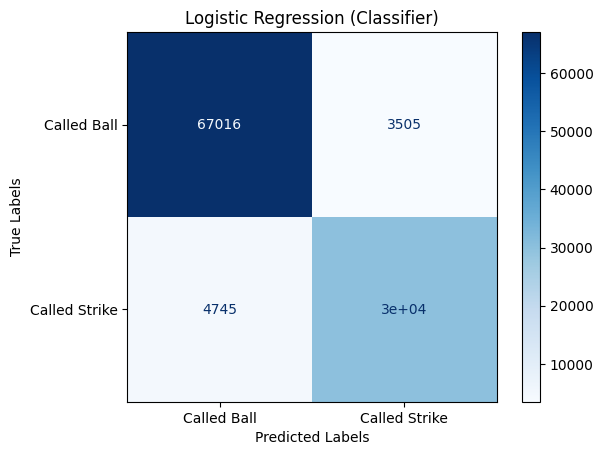

In [95]:
conf_matrix = confusion_matrix(y_test,preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["Called Ball", "Called Strike"])

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax) 

ax.set_title('Logistic Regression (Classifier)')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

In [96]:
report = classification_report(y_test, preds, target_names=['Called Ball', 'Called Strike'])
print("\nClassification Report:\n")
print(report)


Classification Report:

               precision    recall  f1-score   support

  Called Ball       0.93      0.95      0.94     70521
Called Strike       0.90      0.86      0.88     34739

     accuracy                           0.92    105260
    macro avg       0.91      0.91      0.91    105260
 weighted avg       0.92      0.92      0.92    105260



### XGBoost Classifier

In [97]:
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=23)

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=23)),
    ('xgb_classifier', xgb_classifier)
])

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

pipeline_xgb.fit(X_train, y_train)

preds = pipeline_xgb.predict(X_test)

test_accuracy = accuracy_score(y_test, preds)
test_precision = precision_score(y_test, preds)
test_recall = recall_score(y_test, preds)
test_f1 = f1_score(y_test, preds)

print("Test set evaluation")
print("Accuracy: {:.2f}".format(test_accuracy))
print("Precision: {:.2f}".format(test_precision))
print("Recall: {:.2f}".format(test_recall))
print("F1: {:.2f}".format(test_f1))


Test set evaluation
Accuracy: 0.94
Precision: 0.89
Recall: 0.92
F1: 0.90


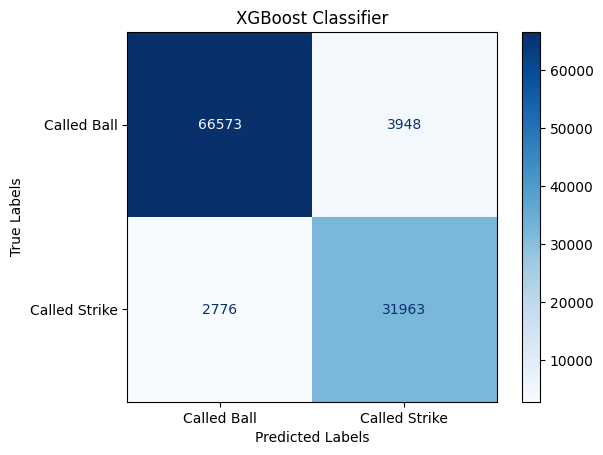

In [98]:
conf_matrix = confusion_matrix(y_test,preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["Called Ball", "Called Strike"])

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax) 

ax.set_title('XGBoost Classifier')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

In [99]:
report = classification_report(y_test, preds, target_names=['Called Ball', 'Called Strike'])
print("\nClassification Report:\n")
print(report)


Classification Report:

               precision    recall  f1-score   support

  Called Ball       0.96      0.94      0.95     70521
Called Strike       0.89      0.92      0.90     34739

     accuracy                           0.94    105260
    macro avg       0.93      0.93      0.93    105260
 weighted avg       0.94      0.94      0.94    105260



#### Hyperparamater Tuning

In [101]:
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=23)),
    ('xgb_classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=23))
])

param_grid = {
    'xgb_classifier__n_estimators': [50, 100], # number of boosting rounds
    'xgb_classifier__max_depth': [3, 5], # maximum depth of a tree
    'xgb_classifier__learning_rate': [0.01, 0.1], # shrinks the contribution of each tree by learning_rate
    'xgb_classifier__subsample': [0.8, 1.0], # subsample ratio of the training instances
    'xgb_classifier__colsample_bytree': [0.8, 1.0] # subsample ratio of columns when constructing each tree
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

grid_search = GridSearchCV(estimator=pipeline_xgb, param_grid=param_grid, scoring=scoring, refit='accuracy', cv=3, n_jobs=-1)

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

preds = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, preds)
test_precision = precision_score(y_test, preds)
test_recall = recall_score(y_test, preds)
test_f1 = f1_score(y_test, preds)

print("Grid Search elapsed time: {:.2f} seconds".format(elapsed_time))
print("Best hyperparameters: ", best_params)
print("Test set evaluation")
print("Accuracy: {:.2f}".format(test_accuracy))
print("Precision: {:.2f}".format(test_precision))
print("Recall: {:.2f}".format(test_recall))
print("F1: {:.2f}".format(test_f1))

Python(96736) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96737) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96738) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96739) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96740) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96741) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(96743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Grid Search elapsed time: 20459.14 seconds
Best hyperparameters:  {'xgb_classifier__colsample_bytree': 0.8, 'xgb_classifier__learning_rate': 0.1, 'xgb_classifier__max_depth': 5, 'xgb_classifier__n_estimators': 100, 'xgb_classifier__subsample': 0.8}
Test set evaluation
Accuracy: 0.93
Precision: 0.88
Recall: 0.93
F1: 0.90


In [ ]:
grid_search.best_params_

{'xgb_classifier__colsample_bytree': 0.8,
 'xgb_classifier__learning_rate': 0.1,
 'xgb_classifier__max_depth': 5,
 'xgb_classifier__n_estimators': 100,
 'xgb_classifier__subsample': 0.8}

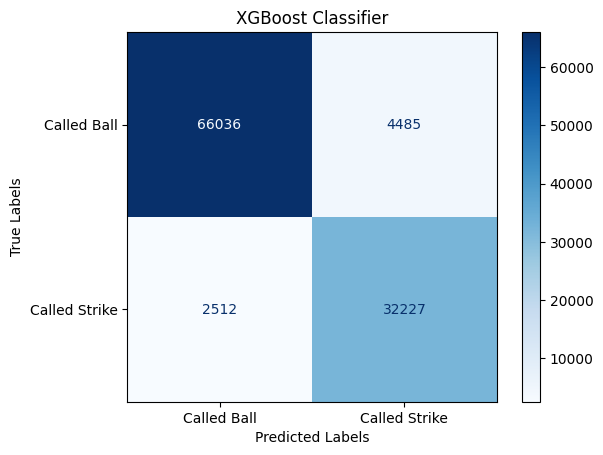

In [102]:
conf_matrix = confusion_matrix(y_test,preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["Called Ball", "Called Strike"])

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax) 

ax.set_title('XGBoost Classifier')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

In [103]:
report = classification_report(y_test, preds, target_names=['Called Ball', 'Called Strike'])
print("\nClassification Report:\n")
print(report)


Classification Report:

               precision    recall  f1-score   support

  Called Ball       0.96      0.94      0.95     70521
Called Strike       0.88      0.93      0.90     34739

     accuracy                           0.93    105260
    macro avg       0.92      0.93      0.93    105260
 weighted avg       0.94      0.93      0.93    105260



### Multi-Layer Perceptron Classifier

In [104]:
def create_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Nadam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

X_train_transformed = preprocessor.fit_transform(X_train)
input_shape = X_train_transformed.shape[1]

keras_clf = KerasClassifier(model=create_model, model__input_shape=input_shape, epochs=50, batch_size=32, verbose=0)

pipeline_keras = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=23)),
    ('keras_clf', keras_clf)
])

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

pipeline_keras.fit(X_train, y_train)

preds = pipeline_keras.predict(X_test)

test_accuracy = accuracy_score(y_test, preds)
test_precision = precision_score(y_test, preds)
test_recall = recall_score(y_test, preds)
test_f1 = f1_score(y_test, preds)

print("Test set evaluation")
print("Accuracy: {:.2f}".format(test_accuracy))
print("Precision: {:.2f}".format(test_precision))
print("Recall: {:.2f}".format(test_recall))
print("F1: {:.2f}".format(test_f1))

Test set evaluation
Accuracy: 0.93
Precision: 0.90
Recall: 0.88
F1: 0.89


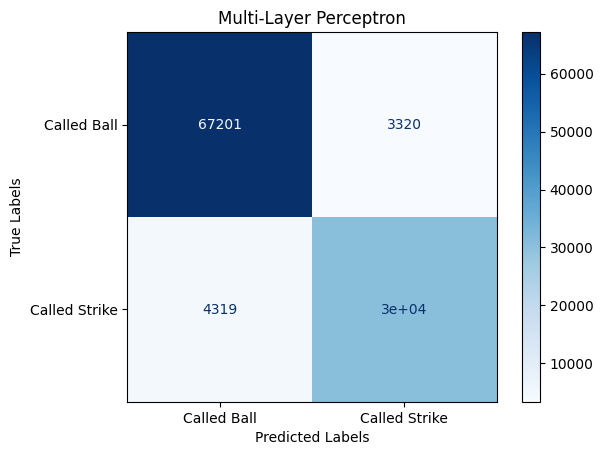

In [105]:
conf_matrix = confusion_matrix(y_test,preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["Called Ball", "Called Strike"])

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax) 

ax.set_title('Multi-Layer Perceptron')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

In [106]:
report = classification_report(y_test, preds, target_names=['Called Ball', 'Called Strike'])
print("\nClassification Report:\n")
print(report)


Classification Report:

               precision    recall  f1-score   support

  Called Ball       0.94      0.95      0.95     70521
Called Strike       0.90      0.88      0.89     34739

     accuracy                           0.93    105260
    macro avg       0.92      0.91      0.92    105260
 weighted avg       0.93      0.93      0.93    105260

